In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
import sys

sys.path.append("../")

import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from pathlib import Path
from scipy.spatial import KDTree
from IPython.display import display
from typing import List, Tuple
from matplotlib import pyplot as plt

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
tqdm.pandas()

from src.config import (
    TRACKING_PATH, 
    DEPTH_SEG_PFM_PATH,
    RAW_GAZE_FRAME_WIDTH, 
    RAW_GAZE_FRAME_HEIGHT, 
    IMAGE_WIDTH, 
    IMAGE_HEIGHT, 
    SETS_PATH,
)
from src.utils.gaze_data import get_gaze_data
from src.utils.file import get_files_recursive, get_sequence_id_from_file_path

N_NSEC_IN_SEC = 1e9
N_NSEC_IN_MSEC = 1e6
BOUNDING_BOX_MARGIN_PX = 30
MAX_TIME_SINCE_START_SEC = 60
FPS = 25
SEED = 0

## Utility Functions

In [3]:
def bootstrap(
        data: pd.Series,
        aggregation_function: callable,
        n_bootstrap: int = 10_000, 
        n_samples: int | None = None,
        seed: int | None = None
    ) -> np.ndarray:
    """
    Perform bootstrap sampling on a dataset.
    
    Args:
        fixation_durations (pd.Series): Series of fixation durations.
        aggregation_function (callable): Function to aggregate the bootstrapped samples.
        n_bootstrap (int, optional): Number of bootstrap samples. Defaults to 10000.
        n_samples (int | None, optional): Number of samples to draw for each bootstrap sample. Defaults to None.
        seed (int | None, optional): Seed for the random number generator. Defaults to None.
        
    Returns:
        np.ndarray: Array of bootstrapped means.
    """
    if seed is not None:
        np.random.seed(seed)
        
    data = np.asarray(data)
    data_size = len(data)

    # Take a maximum of the data size samples
    if n_samples is None or n_samples > data_size:
        n_samples = data_size

    # Perform the bootstrapping
    bootstrapped_values = np.empty(n_bootstrap)
    for i in range(n_bootstrap):
        boot_sample = np.random.choice(data, size=n_samples, replace=True)
        bootstrapped_values[i] = aggregation_function(boot_sample)

    return bootstrapped_values

## Get Fixation and Object Data

In [4]:
def get_fixation_data() -> pd.DataFrame:
    """
    Get fixation data for videos of experiment 1.

    Returns:
        pd.DataFrame: Fixation data for videos
    """
    fixation_data = get_gaze_data(
        experiment_ids=[1],
        set_ids=[0],
        fixation=True,
    )

    # Filter out fixations that are after the max time since start
    fixation_data = fixation_data[fixation_data["TimeSinceStart_ns"] < MAX_TIME_SINCE_START_SEC * N_NSEC_IN_SEC]

    # Sort data and add Fixation Id
    fixation_data = fixation_data.sort_values(by=["SequenceId", "StartTimestamp_ns"])
    fixation_data["FixationId"] = np.arange(len(fixation_data))

    fixation_data = fixation_data[[
        "FixationId",
        "SequenceId",
        "X_px",
        "Y_px",
        "StartTimestamp_ns",
        "EndTimestamp_ns",
        "Duration_ns",
        "TimeSinceStart_ns",
    ]]

    return fixation_data

fixation_data = get_fixation_data()
fixation_data

,FixationId,SequenceId,X_px,Y_px,StartTimestamp_ns,EndTimestamp_ns,Duration_ns,TimeSinceStart_ns
10249,0,1,2908.8635,2134.9172,8492823774425000000,8492823774750000000,325000000,500000000
10250,1,1,3169.3774,2228.1470,8492823774850000000,8492823775050000000,200000000,925000000
10251,2,1,3098.8755,2317.7788,8492823775050000000,8492823775175000000,125000000,1125000000
10252,3,1,3029.5054,2377.7527,8492823775175000000,8492823775300000000,125000000,1250000000
10253,4,1,3514.5747,2555.8682,8492823775400000000,8492823775600000000,200000000,1475000000
...,...,...,...,...,...,...,...,...
275820,97878,15,3888.6738,1682.3688,8496629094325000000,8496629094475000000,150000000,58600000000
275821,97879,15,4604.8584,1750.6029,8496629094575000000,8496629094700000000,125000000,58850000000
275822,97880,15,4653.3530,1776.2250,8496629094700000000,8496629094875000000,175000000,58975000000
275823,97881,15,4837.4097,1861.8182,8496629094975000000,8496629095350000000,375000000,59250000000


✅ Loaded tracking data.


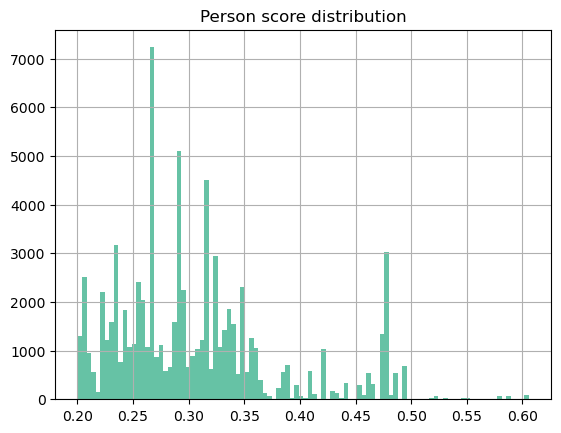

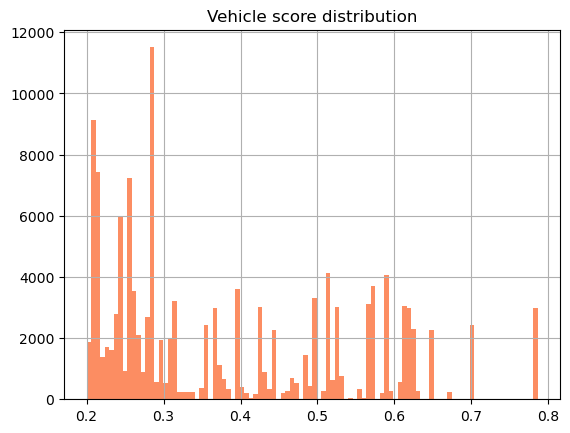

100%|██████████| 83270/83270 [01:20<00:00, 1040.62it/s]


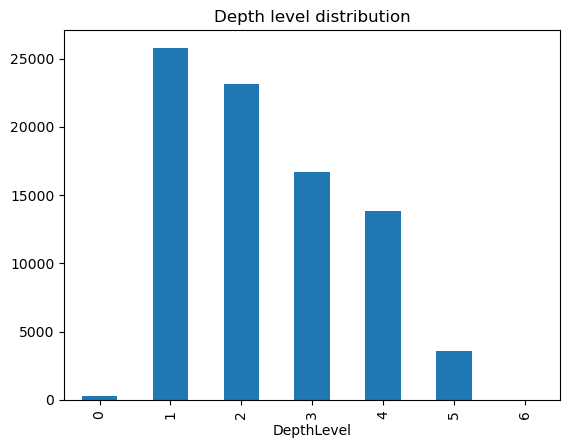

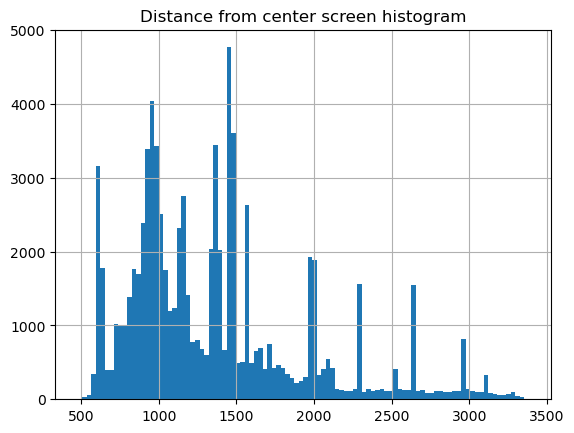

✅ Successfully processed tracking data with 83_270 entries.


,ObjectId,SequenceId,InstanceId,FrameId,LabelStr,LabelClass,CenterX_px,CenterY_px,Width_px,Height_px,Area_px2,DistanceFromLast_px,AngleFromLast_deg,DepthLevel,DistanceFromCenter_px,TimeSinceStart_ns,TimeSinceAppearance_ns,StartTime_ns,Lifetime_ns,MeanDistanceFromLast_px
0,0,1,0,0,car,vehicle,3345.136477,2487.543314,411.410548,392.460609,161462.434515,NaN,NaN,2,989.968794,0.000000e+00,0.000000e+00,0.0,5.996000e+10,0.018109
1500,1,1,1,0,car,vehicle,3443.219011,2936.978634,670.837358,369.262080,247714.798254,NaN,NaN,4,1449.325597,0.000000e+00,0.000000e+00,0.0,5.996000e+10,0.011025
3000,2,1,2,0,car,vehicle,2961.097976,2967.986337,349.622833,307.482338,107502.846105,NaN,NaN,4,1436.274392,0.000000e+00,0.000000e+00,0.0,2.224000e+10,1.029474
3424,3,1,9,0,person,person,2649.610392,2287.387936,190.871720,300.699505,57395.031604,NaN,NaN,2,861.972628,0.000000e+00,0.000000e+00,0.0,3.992000e+10,1.005619
1,4,1,0,1,car,vehicle,3345.117696,2487.538517,411.487989,392.537981,161524.664541,0.007446,-169.611142,2,989.959002,4.000000e+07,4.000000e+07,0.0,5.996000e+10,0.018109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83231,83265,14,1,1497,car,vehicle,3630.323977,2783.352907,695.695172,588.465176,409392.381676,0.007614,48.900494,3,1366.607090,5.988000e+10,5.988000e+10,0.0,5.996000e+10,0.043760
81732,83266,14,0,1498,car,vehicle,3956.667258,2729.046366,698.526643,568.548614,397146.354728,0.062019,-8.090231,3,1485.259502,5.992000e+10,5.992000e+10,0.0,5.996000e+10,0.038930
83232,83267,14,1,1498,car,vehicle,3630.512417,2783.458866,696.135201,588.327293,409555.338580,0.079247,21.981687,3,1366.780795,5.992000e+10,5.992000e+10,0.0,5.996000e+10,0.043760
81733,83268,14,0,1499,car,vehicle,3956.738314,2728.942151,698.592801,568.689176,397282.164421,0.040237,-46.475102,3,1485.218119,5.996000e+10,5.996000e+10,0.0,5.996000e+10,0.038930


In [5]:
def get_majority_depth_level(
    row: pd.Series, 
    depth_segs: np.ndarray,
    bounding_box_margin_px: int,
    ) -> int:
    """
    Get median depth level for an object.

    Args:
        row (pd.Series): Object data
        depth_segs (np.ndarray): Depth segmentation image

    Returns:
        int: Median depth level
    """
    sequence_id = row["SequenceId"]
    bounding_box = row["BoundingBox_px"]

    x_min, y_min, x_max, y_max = bounding_box
    x_min, x_max = int(x_min), int(x_max)
    y_min, y_max = int(y_min), int(y_max)

    # Remove margin
    x_min = max(x_min + bounding_box_margin_px, 0)
    x_max = min(x_max - bounding_box_margin_px, RAW_GAZE_FRAME_WIDTH)
    y_min = max(y_min + bounding_box_margin_px, 0)
    y_max = min(y_max - bounding_box_margin_px, RAW_GAZE_FRAME_HEIGHT)

    depth_values = depth_segs[sequence_id][y_min:y_max, x_min:x_max].flatten()

    # Remove NaN values and get mode
    depth_values = depth_values[~np.isnan(depth_values)]
    if len(depth_values) == 0:
        return np.na
    depth_value = np.bincount(depth_values.astype(int)).argmax()

    return depth_value


def get_object_data(
        person_score_threshold: float = 0.2,
        vehicle_score_threshold: float = 0.3,
        bounding_box_margin_px: int = BOUNDING_BOX_MARGIN_PX,
        min_lifetime_ns: int = 1 / FPS * N_NSEC_IN_SEC,
):
    """
    Get tracking data for objects.

    Args:
        person_score_threshold (float): Minimum score for a person object to be considered
        vehicle_score_threshold (float): Minimum score for a vehicle object to be considered
        bounding_box_margin_px (int): Margin to add to bounding box

    Returns:
        pd.DataFrame: Tracking data for objects
    """
    # Concatenate all tracking data
    all_tracking_data = []
    depth_segs = {}
    tracking_file_paths = sorted(get_files_recursive(TRACKING_PATH, "scene*.csv"))
    for tracking_file_path in tracking_file_paths:
        tracking_path_prefix = Path(TRACKING_PATH).resolve().as_posix()
        depth_seg_path_prefix = Path(DEPTH_SEG_PFM_PATH).resolve().as_posix()
        depth_seg_file_path = tracking_file_path.replace(tracking_path_prefix, depth_seg_path_prefix).replace(".csv", ".pfm")

        sequence_id = get_sequence_id_from_file_path(tracking_file_path)
        tracking_data = pd.read_csv(tracking_file_path)
        tracking_data["SequenceId"] = sequence_id
        all_tracking_data.append(tracking_data)

        depth_seg = cv2.imread(depth_seg_file_path, cv2.IMREAD_UNCHANGED)
        depth_seg = cv2.resize(depth_seg, (RAW_GAZE_FRAME_WIDTH, RAW_GAZE_FRAME_HEIGHT), interpolation=cv2.INTER_NEAREST)
        depth_segs[sequence_id] = depth_seg
    all_tracking_data = pd.concat(all_tracking_data)
    print(f"✅ Loaded tracking data.")

    # Merge vehicle classes
    all_tracking_data["LabelClass"] = all_tracking_data["LabelStr"].replace(
        {
            "truck": "vehicle",
            "bus": "vehicle",
            "car": "vehicle",
            "motorcycle": "vehicle",
            "bike": "vehicle",
        }
    )

    # Remove objects that are not people or vehicles
    all_tracking_data = all_tracking_data[~all_tracking_data["LabelClass"].str.contains("building")]

    # Plot score distributions before filtering
    colors = sns.color_palette("Set2", n_colors=2)
    all_tracking_data[all_tracking_data["LabelClass"] == "person"]["Score"].hist(bins=100, color=colors[0])
    plt.title("Person score distribution")
    plt.show()
    all_tracking_data[all_tracking_data["LabelClass"] == "vehicle"]["Score"].hist(bins=100, color=colors[1])
    plt.title("Vehicle score distribution")
    plt.show()

    # Filter out objects with low scores
    all_tracking_data = all_tracking_data[
        ((all_tracking_data["LabelClass"] == "person")
        & (all_tracking_data["Score"] > person_score_threshold))
        | ((all_tracking_data["LabelClass"] == "vehicle")
        & (all_tracking_data["Score"] > vehicle_score_threshold))
    ]

    # Filter out objects that are after the max time since start
    all_tracking_data = all_tracking_data[all_tracking_data["TimeSinceStart_ns"] < MAX_TIME_SINCE_START_SEC * N_NSEC_IN_SEC]

    # Get distance and angle from last frame
    all_tracking_data = all_tracking_data.sort_values(["SequenceId", "InstanceId", "FrameId"])
    all_tracking_data["CenterXDiff_px"] = all_tracking_data.groupby(["SequenceId", "InstanceId"])["CenterX_px"].diff()
    all_tracking_data["CenterYDiff_px"] = all_tracking_data.groupby(["SequenceId", "InstanceId"])["CenterY_px"].diff()
    all_tracking_data["DistanceFromLast_px"] = np.sqrt(all_tracking_data["CenterXDiff_px"]**2 + all_tracking_data["CenterYDiff_px"]**2)
    all_tracking_data["AngleFromLast_deg"] = np.arctan2(all_tracking_data["CenterYDiff_px"], all_tracking_data["CenterXDiff_px"]).apply(np.degrees)
    all_tracking_data = all_tracking_data.drop(columns=["CenterXDiff_px", "CenterYDiff_px"])

    # Transform pixel space to the same space as fixation data
    all_tracking_data["CenterX_px"] = all_tracking_data["CenterX_px"] / IMAGE_WIDTH * RAW_GAZE_FRAME_WIDTH
    all_tracking_data["CenterY_px"] = all_tracking_data["CenterY_px"] / IMAGE_HEIGHT * RAW_GAZE_FRAME_HEIGHT

    # Add bounding box margin and clip to image size, and transform to the same space as fixation data
    all_tracking_data["BoundingBox_px"] = all_tracking_data["BoundingBox_px"].apply(lambda x: list(map(float, x.strip("[]").split())))
    all_tracking_data["BoundingBox_px"] = all_tracking_data["BoundingBox_px"].apply(lambda x: [x[0] - bounding_box_margin_px, x[1] - bounding_box_margin_px, x[2] + bounding_box_margin_px, x[3] + bounding_box_margin_px])
    all_tracking_data["BoundingBox_px"] = all_tracking_data["BoundingBox_px"].apply(lambda x: [max(0, x[0]), max(0, x[1]), min(IMAGE_WIDTH, x[2]), min(IMAGE_HEIGHT, x[3])])
    all_tracking_data["BoundingBox_px"] = all_tracking_data["BoundingBox_px"].apply(lambda x: [x[0] / IMAGE_WIDTH * RAW_GAZE_FRAME_WIDTH, x[1] / IMAGE_HEIGHT * RAW_GAZE_FRAME_HEIGHT, x[2] / IMAGE_WIDTH * RAW_GAZE_FRAME_WIDTH, x[3] / IMAGE_HEIGHT * RAW_GAZE_FRAME_HEIGHT])
    
    # Get width and height of bounding box
    all_tracking_data["Width_px"] = all_tracking_data["BoundingBox_px"].apply(lambda x: x[2] - x[0])
    all_tracking_data["Height_px"] = all_tracking_data["BoundingBox_px"].apply(lambda x: x[3] - x[1])
    all_tracking_data["Area_px2"] = all_tracking_data["Width_px"] * all_tracking_data["Height_px"]

    # Get start time, lifetime and mean distance from last for each object
    other_data = all_tracking_data.groupby(["SequenceId", "InstanceId"]).agg(
        StartTime_ns=("TimeSinceStart_ns", "min"),
        Lifetime_ns=("TimeSinceStart_ns", lambda x: max(x.max() - x.min(), min_lifetime_ns)),
        MeanDistanceFromLast_px=("DistanceFromLast_px", "mean")
    ).reset_index()
    all_tracking_data = all_tracking_data.merge(other_data, on=["SequenceId", "InstanceId"], how="left")

    # Get time since appearance
    all_tracking_data["TimeSinceAppearance_ns"] = all_tracking_data["TimeSinceStart_ns"] - all_tracking_data["StartTime_ns"]

    # Get depth level for each object
    all_tracking_data["DepthLevel"] = all_tracking_data.progress_apply(lambda x: get_majority_depth_level(x, depth_segs, bounding_box_margin_px), axis=1)

    # Plot bar chart of depth levels
    all_tracking_data["DepthLevel"].value_counts().sort_index().plot(kind="bar")
    plt.title("Depth level distribution")
    plt.show()

    # Get distance from center screen
    all_tracking_data["DistanceFromCenter_px"] = np.sqrt(
        (all_tracking_data["CenterX_px"] - RAW_GAZE_FRAME_WIDTH / 2)**2
        + (all_tracking_data["CenterY_px"] - RAW_GAZE_FRAME_HEIGHT / 2)**2
    )

    # Plot distance from center screen histogram
    all_tracking_data["DistanceFromCenter_px"].hist(bins=100)
    plt.title("Distance from center screen histogram")
    plt.show()

    # Sort data and add Object Id
    all_tracking_data = all_tracking_data.sort_values(by=["SequenceId", "FrameId", "InstanceId"])
    all_tracking_data["ObjectId"] = np.arange(len(all_tracking_data))

    # Remove unnecessary columns and reorder
    all_tracking_data = all_tracking_data[[
        "ObjectId",
        "SequenceId",
        "InstanceId",
        "FrameId",
        "LabelStr",
        "LabelClass",
        "CenterX_px",
        "CenterY_px",
        "Width_px",
        "Height_px",
        "Area_px2",
        "DistanceFromLast_px",
        "AngleFromLast_deg",
        "DepthLevel",
        "DistanceFromCenter_px",
        "TimeSinceStart_ns",
        "TimeSinceAppearance_ns",
        "StartTime_ns",
        "Lifetime_ns",
        "MeanDistanceFromLast_px",
    ]]

    print(f"✅ Successfully processed tracking data with {len(all_tracking_data):_} entries.")

    return all_tracking_data

object_data = get_object_data()
object_data

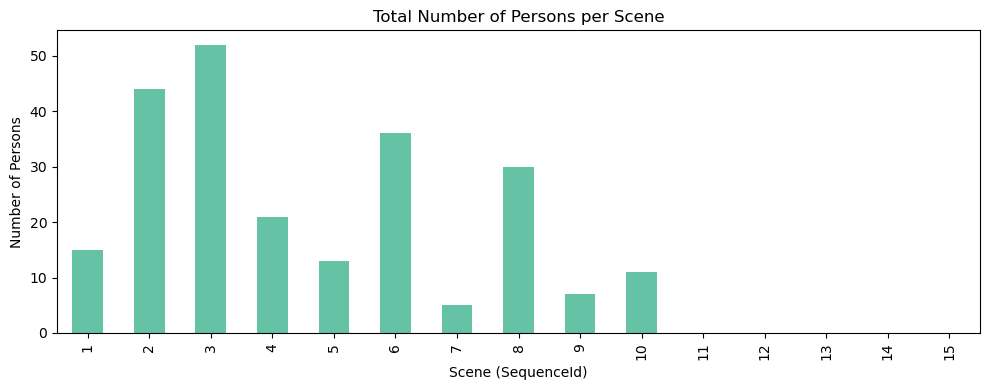

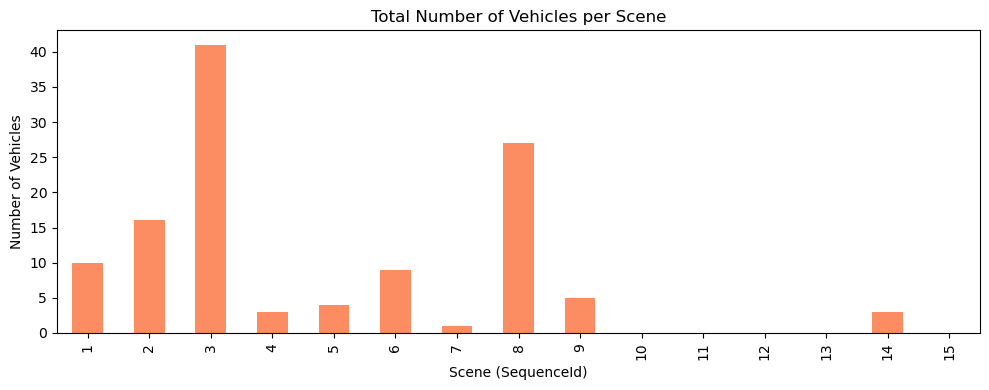

In [6]:
def plot_object_counts(data: pd.DataFrame) -> None:
    """
    Plot the total number of objects per scene.

    Args:
        object_data (pd.DataFrame): Tracking data for objects
    """
    data = data.copy()
    colors = sns.color_palette('Set2', n_colors=2)
    for i, obj_type in enumerate(['person', 'vehicle']):
        filtered_data = data[data["LabelClass"] == obj_type]
        filtered_data = filtered_data.drop_duplicates(subset=['SequenceId', 'InstanceId'])
        object_counts = filtered_data.groupby('SequenceId').size()
        object_counts = object_counts.reindex(range(1, 16), fill_value=0)
        
        # Create the bar plot
        plt.figure(figsize=(10, 4))
        object_counts.plot(kind='bar', color=colors[i])
        plt.title(f'Total Number of {obj_type.capitalize()}s per Scene')
        plt.xlabel('Scene (SequenceId)')
        plt.ylabel(f'Number of {obj_type.capitalize()}s')
        plt.tight_layout()
        plt.show()

plot_object_counts(object_data)

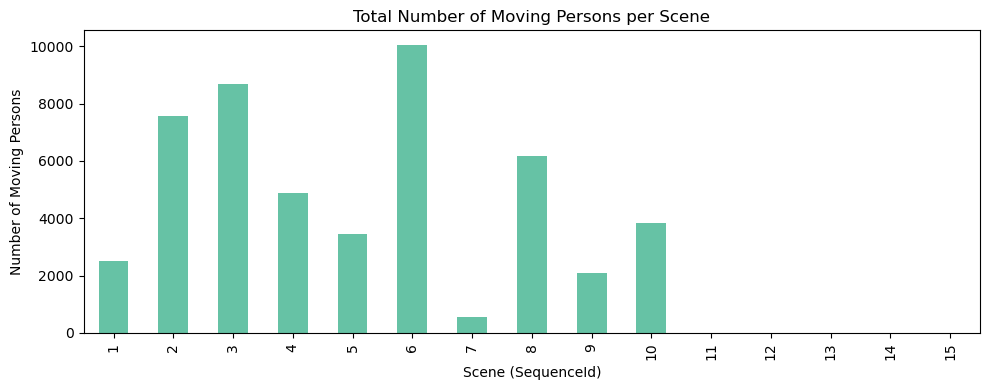

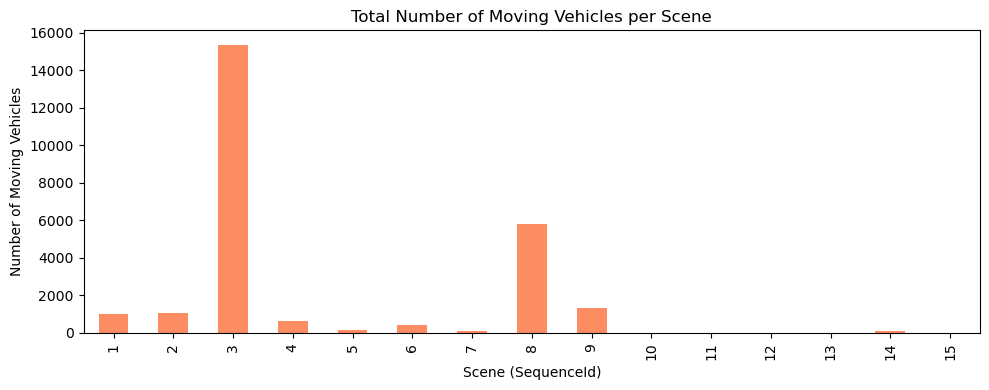

In [7]:
def plot_object_motion(data: pd.DataFrame) -> None:
    """
    Plot the total number of moving objects per scene.

    Args:
        object_data (pd.DataFrame): Tracking data for objects
        object_types (List[str]): Types of objects to plot
    """
    data = data.copy()
    colors = sns.color_palette("Set2", n_colors=2)
    for i, obj_type in enumerate(['person', 'vehicle']):
        motion_data = data[data["LabelClass"] == obj_type]
        motion_data = (
            motion_data.groupby(["SequenceId", "InstanceId"])["DistanceFromLast_px"]
            .sum()
            .reset_index()
        )
        motion_data = motion_data.groupby("SequenceId")["DistanceFromLast_px"].sum()
        motion_data = motion_data.reindex(range(1, 16), fill_value=0)

        # Plot the bar plot
        plt.figure(figsize=(10, 4))
        motion_data.plot(kind="bar", color=colors[i])
        plt.title(f"Total Number of Moving {obj_type.capitalize()}s per Scene")
        plt.xlabel("Scene (SequenceId)")
        plt.ylabel(f"Number of Moving {obj_type.capitalize()}s")
        plt.tight_layout()
        plt.show()

plot_object_motion(data=object_data)

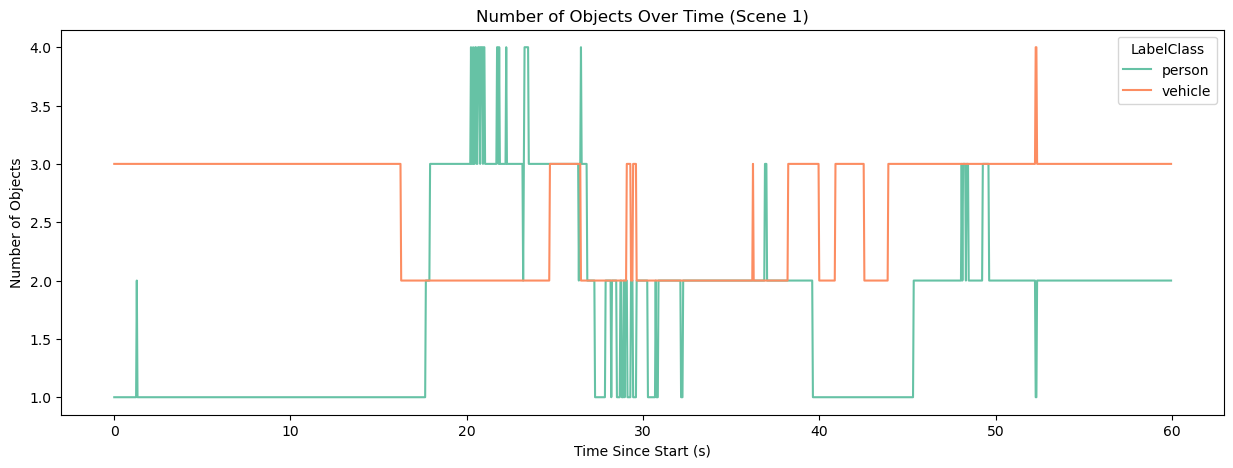

In [8]:
def plot_objects_over_time(
    data: pd.DataFrame,
    sequence_id: int,
):
    """
    Plot the number of objects over time for a specific scene.

    Args:
        data (pd.DataFrame): Tracking data for objects
        sequence_id (int): Sequence ID of the scene
    """
    data = data.copy()
    data = data[data["SequenceId"] == sequence_id]
    data = data[data["LabelClass"].isin(['person', 'vehicle'])]
    data["TimeSinceStart_s"] = data["TimeSinceStart_ns"] / N_NSEC_IN_SEC
    unique_data = data[["InstanceId", "LabelClass", "TimeSinceStart_s"]].copy().drop_duplicates(subset=["InstanceId", "TimeSinceStart_s"])
    unique_data = unique_data.groupby(["TimeSinceStart_s", "LabelClass"]).size().reset_index(name="Count")

    # Plot the line plot
    plt.figure(figsize=(15, 5))
    colors = sns.color_palette("Set2", n_colors=len(unique_data["LabelClass"].unique()))
    sns.lineplot(data=unique_data, x="TimeSinceStart_s", y="Count", hue="LabelClass", palette=colors)
    plt.title(f"Number of Objects Over Time (Scene {sequence_id})")
    plt.xlabel("Time Since Start (s)")
    plt.ylabel("Number of Objects")
    plt.show()

plot_objects_over_time(data=object_data, sequence_id=1)

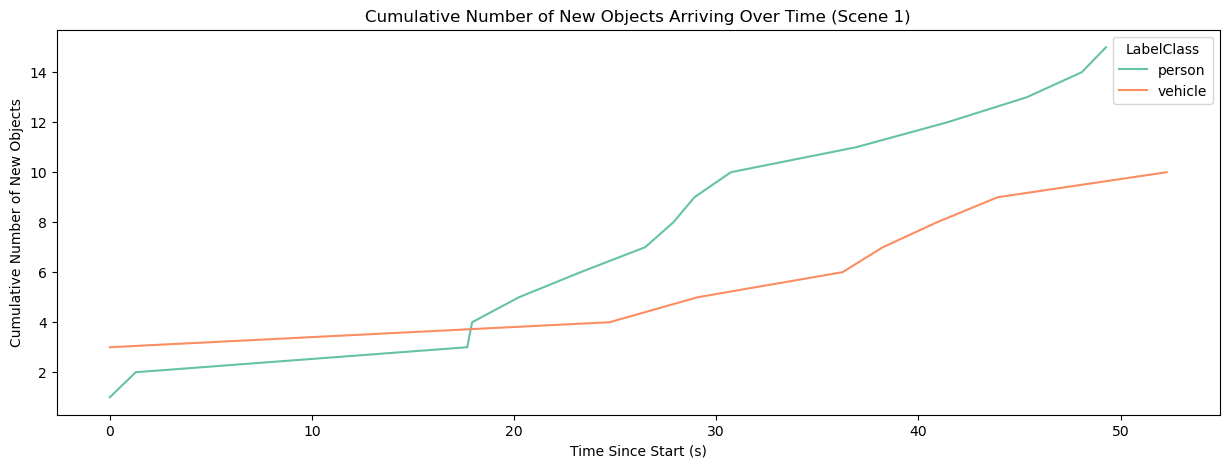

In [9]:
def plot_objects_cumulative_over_time(
    data: pd.DataFrame,
    sequence_id: int,
) -> None:
    """
    Plot the cumulative number of new objects arriving over time for a specific scene.

    Args:
        data (pd.DataFrame): Tracking data for objects
        sequence_id (int): Sequence ID of the scene
    """
    data = data.copy()
    data = data[data["SequenceId"] == sequence_id]
    data = data[data["LabelClass"].isin(['person', 'vehicle'])]
    data["TimeSinceStart_s"] = data["TimeSinceStart_ns"] / N_NSEC_IN_SEC
    unique_data = data[["InstanceId", "LabelClass", "TimeSinceStart_s"]].copy().drop_duplicates(subset=["InstanceId", "TimeSinceStart_s"])
    unique_data = unique_data.sort_values(by="TimeSinceStart_s")

    # Calculate cumulative count of new objects arriving in the scene
    unique_data["NewObject"] = ~unique_data.duplicated(subset=["InstanceId", "LabelClass"], keep="first")
    unique_data = unique_data[unique_data["NewObject"]]
    unique_data = unique_data.groupby(["TimeSinceStart_s", "LabelClass"]).size().reset_index(name="NewCount")
    unique_data["CumulativeNewObjects"] = unique_data.groupby("LabelClass")["NewCount"].cumsum()

    # Plot the line plot
    plt.figure(figsize=(15, 5))
    colors = sns.color_palette("Set2", n_colors=len(unique_data["LabelClass"].unique()))
    sns.lineplot(data=unique_data, x="TimeSinceStart_s", y="CumulativeNewObjects", hue="LabelClass", palette=colors)
    plt.title(f"Cumulative Number of New Objects Arriving Over Time (Scene {sequence_id})")
    plt.xlabel("Time Since Start (s)")
    plt.ylabel("Cumulative Number of New Objects")
    plt.show()

plot_objects_cumulative_over_time(data=object_data, sequence_id=1)

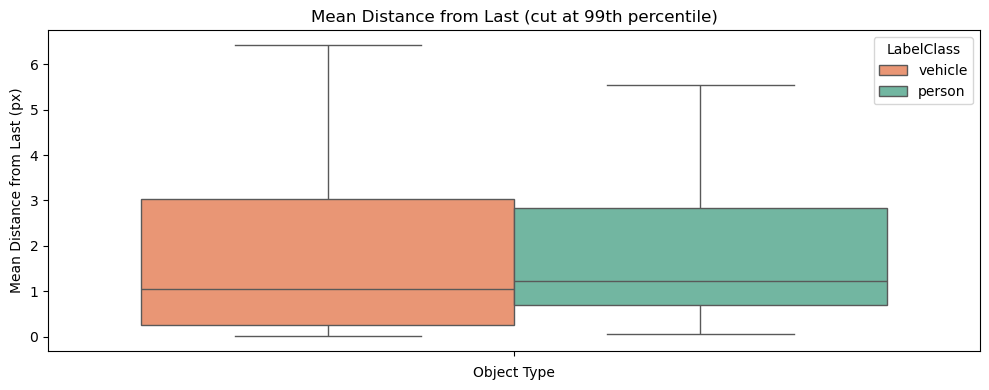

In [10]:
def plot_distance_distribution(data: pd.DataFrame) -> None:
    """
    Plot the distribution of mean distance from last for each object type.

    Args:
        data (pd.DataFrame): Tracking data for objects
        object_types (List[str]): Types of objects to plot
    """
    # Only keep the first instance of each object
    data = data.copy()
    data = data.groupby(["SequenceId", "InstanceId", "MeanDistanceFromLast_px"]).first().reset_index()

    # Remove outliers
    distance_threshold = data["MeanDistanceFromLast_px"].quantile(0.99)
    data = data[data["MeanDistanceFromLast_px"] < distance_threshold]

    # Plot the box plot
    colors = sns.color_palette("Set2", n_colors=len(data["LabelClass"].unique()))[::-1]
    plt.figure(figsize=(10, 4))
    sns.boxplot(data=data, y="MeanDistanceFromLast_px", palette=colors, hue="LabelClass", showfliers=False)
    plt.title("Mean Distance from Last (cut at 99th percentile)")
    plt.xlabel("Object Type")
    plt.ylabel("Mean Distance from Last (px)")
    plt.tight_layout()
    plt.show()

plot_distance_distribution(object_data)

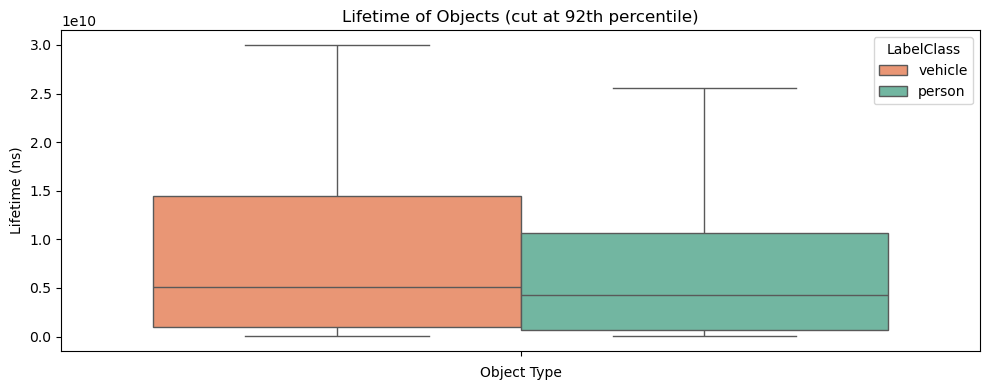

In [11]:
def plot_lifetime_distribution(data: pd.DataFrame) -> None:
    """
    Plot the distribution of lifetime for each object type.

    Args:
        data (pd.DataFrame): Tracking data for objects
    """
    # Only keep the first instance of each object
    data = data.copy()
    data = data.groupby(["SequenceId", "InstanceId", "Lifetime_ns"]).first().reset_index()

    # Remove outliers
    lifetime_threshold = data["Lifetime_ns"].quantile(0.92)
    data = data[data["Lifetime_ns"] < lifetime_threshold]

    # Plot the box plot
    colors = sns.color_palette("Set2", n_colors=len(data["LabelClass"].unique()))[::-1]
    plt.figure(figsize=(10, 4))
    sns.boxplot(data=data, y="Lifetime_ns", hue="LabelClass", palette=colors, showfliers=False)
    plt.title("Lifetime of Objects (cut at 92th percentile)")
    plt.xlabel("Object Type")
    plt.ylabel("Lifetime (ns)")
    plt.tight_layout()
    plt.show()

# Call the function with the appropriate data
plot_lifetime_distribution(object_data)

## Merge Data

In [12]:
def merge_data(
    fixation_data: pd.DataFrame,
    object_data: pd.DataFrame,
    time_threshold_ns: float = 2 / FPS * N_NSEC_IN_SEC, # 2 frames
) -> pd.DataFrame:
    """
    Merge gaze and object tracking data.

    Args:
        gaze_data (pd.DataFrame): Gaze data
        object_data (pd.DataFrame): Tracking data for objects
        time_threshold_s (float): Maximum time difference between gaze point and object

    Returns:
        pd.DataFrame: Merged data
    """
    merged_data = []
    for sequence_id in tqdm(
        fixation_data["SequenceId"].unique(), desc="⌛ Processing sequences..."
    ):
        # Get sequence data
        gaze_sequence_data = fixation_data[fixation_data["SequenceId"] == sequence_id]
        object_sequence_data = object_data[object_data["SequenceId"] == sequence_id]

        # Skip if no object data for the sequence
        if object_sequence_data.empty or gaze_sequence_data.empty:
            continue

        # Use KDTree for spatio-temporal-based filtering
        object_times = object_sequence_data["TimeSinceStart_ns"].values.reshape(-1, 1)
        temporal_tree = KDTree(object_times)
        gaze_times = gaze_sequence_data["TimeSinceStart_ns"].values.reshape(-1, 1)
        temporal_indices = temporal_tree.query_ball_point(gaze_times, time_threshold_ns, workers=-1)

        # Iterate over gaze points and query nearest objects within distance threshold
        temporal_matches = []
        for gaze_idx, obj_indices in enumerate(temporal_indices):
            if len(obj_indices) == 0:
                continue

            gaze_row = gaze_sequence_data.iloc[gaze_idx]
            candidate_objects = object_sequence_data.iloc[obj_indices]
            candidate_objects = candidate_objects.assign(
                FixationId=gaze_row["FixationId"].astype(int),
                FixationX_px=gaze_row["X_px"],
                FixationY_px=gaze_row["Y_px"],
                FixationDuration_ns=gaze_row["Duration_ns"],
                FixationTimeSinceStart_ns=gaze_row["TimeSinceStart_ns"],
            )
            temporal_matches.append(candidate_objects)

        if not temporal_matches:
            continue

        temporal_matches = pd.concat(temporal_matches, ignore_index=True)

        # Calculate distances and filter based on spatial distance threshold
        x_min = (
            temporal_matches["CenterX_px"]
            - temporal_matches["Width_px"] / 2
        )
        x_max = (
            temporal_matches["CenterX_px"]
            + temporal_matches["Width_px"] / 2
        )
        y_min = (
            temporal_matches["CenterY_px"]
            - temporal_matches["Height_px"] / 2
        )
        y_max = (
            temporal_matches["CenterY_px"]
            + temporal_matches["Height_px"] / 2
        )
        within_bounds_mask = (
            (temporal_matches["FixationX_px"] >= x_min)
            & (temporal_matches["FixationX_px"] <= x_max)
            & (temporal_matches["FixationY_px"] >= y_min)
            & (temporal_matches["FixationY_px"] <= y_max)
        )
        valid_matches = temporal_matches[within_bounds_mask]

        merged_data.extend(valid_matches.to_dict(orient="records"))
    merged_data = pd.DataFrame(merged_data)

    # At this point, every fixation is linked to every object in a time window defined by time_threshold_ns
    # We need to filter the data to keep only the first fixation for each object
    merged_data = merged_data.sort_values(["SequenceId", "InstanceId", "FixationId", "FixationTimeSinceStart_ns"])
    merged_data = merged_data.groupby(["SequenceId", "InstanceId", "FixationId"], as_index=False).first()

    # Perform outer merge to keep all objects
    collision_columns = [col for col in object_data.columns if col in merged_data.columns and col != "ObjectId"]
    merged_data = pd.merge(
        object_data,
        merged_data.drop(columns=collision_columns),
        on=["ObjectId"],
        how="left",
        suffixes=("", "_")
    )

    # Sort merged data
    merged_data = merged_data.sort_values(["ObjectId"])

    return merged_data

merged_data = merge_data(fixation_data=fixation_data, object_data=object_data)
merged_data_with_fixation = merged_data.dropna(subset=["FixationId"])
display(merged_data)
display(merged_data_with_fixation)

⌛ Processing sequences...: 100%|██████████| 15/15 [00:52<00:00,  3.49s/it]


,ObjectId,SequenceId,InstanceId,FrameId,LabelStr,LabelClass,CenterX_px,CenterY_px,Width_px,Height_px,...,TimeSinceStart_ns,TimeSinceAppearance_ns,StartTime_ns,Lifetime_ns,MeanDistanceFromLast_px,FixationId,FixationX_px,FixationY_px,FixationDuration_ns,FixationTimeSinceStart_ns
0,0,1,0,0,car,vehicle,3345.136477,2487.543314,411.410548,392.460609,...,0.000000e+00,0.000000e+00,0.0,5.996000e+10,0.018109,2913.0,3314.1394,2622.4956,325000000.0,0.0
1,1,1,1,0,car,vehicle,3443.219011,2936.978634,670.837358,369.262080,...,0.000000e+00,0.000000e+00,0.0,5.996000e+10,0.011025,1366.0,3520.8320,3072.0000,150000000.0,0.0
2,2,1,2,0,car,vehicle,2961.097976,2967.986337,349.622833,307.482338,...,0.000000e+00,0.000000e+00,0.0,2.224000e+10,1.029474,NaN,NaN,NaN,NaN,NaN
3,3,1,9,0,person,person,2649.610392,2287.387936,190.871720,300.699505,...,0.000000e+00,0.000000e+00,0.0,3.992000e+10,1.005619,NaN,NaN,NaN,NaN,NaN
4,4,1,0,1,car,vehicle,3345.117696,2487.538517,411.487989,392.537981,...,4.000000e+07,4.000000e+07,0.0,5.996000e+10,0.018109,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84183,83265,14,1,1497,car,vehicle,3630.323977,2783.352907,695.695172,588.465176,...,5.988000e+10,5.988000e+10,0.0,5.996000e+10,0.043760,NaN,NaN,NaN,NaN,NaN
84184,83266,14,0,1498,car,vehicle,3956.667258,2729.046366,698.526643,568.548614,...,5.992000e+10,5.992000e+10,0.0,5.996000e+10,0.038930,NaN,NaN,NaN,NaN,NaN
84185,83267,14,1,1498,car,vehicle,3630.512417,2783.458866,696.135201,588.327293,...,5.992000e+10,5.992000e+10,0.0,5.996000e+10,0.043760,NaN,NaN,NaN,NaN,NaN
84186,83268,14,0,1499,car,vehicle,3956.738314,2728.942151,698.592801,568.689176,...,5.996000e+10,5.996000e+10,0.0,5.996000e+10,0.038930,NaN,NaN,NaN,NaN,NaN


,ObjectId,SequenceId,InstanceId,FrameId,LabelStr,LabelClass,CenterX_px,CenterY_px,Width_px,Height_px,...,TimeSinceStart_ns,TimeSinceAppearance_ns,StartTime_ns,Lifetime_ns,MeanDistanceFromLast_px,FixationId,FixationX_px,FixationY_px,FixationDuration_ns,FixationTimeSinceStart_ns
0,0,1,0,0,car,vehicle,3345.136477,2487.543314,411.410548,392.460609,...,0.000000e+00,0.000000e+00,0.0,5.996000e+10,0.018109,2913.0,3314.1394,2622.4956,325000000.0,0.000000e+00
1,1,1,1,0,car,vehicle,3443.219011,2936.978634,670.837358,369.262080,...,0.000000e+00,0.000000e+00,0.0,5.996000e+10,0.011025,1366.0,3520.8320,3072.0000,150000000.0,0.000000e+00
9,9,1,1,2,car,vehicle,3443.194595,2936.904506,670.869412,369.444543,...,8.000000e+07,8.000000e+07,0.0,5.996000e+10,0.011025,1367.0,3394.0876,3069.1885,375000000.0,1.500000e+08
12,12,1,0,3,car,vehicle,3345.036624,2487.328779,411.835192,392.745555,...,1.200000e+08,1.200000e+08,0.0,5.996000e+10,0.018109,1527.0,3350.9456,2665.7750,200000000.0,1.750000e+08
14,14,1,2,3,car,vehicle,2966.480384,2951.531686,345.968230,340.049325,...,1.200000e+08,1.200000e+08,0.0,2.224000e+10,1.029474,3084.0,3081.3882,3003.0420,125000000.0,2.000000e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84159,83241,14,1,1485,car,vehicle,3629.526085,2783.139244,696.088532,588.677001,...,5.940000e+10,5.940000e+10,0.0,5.996000e+10,0.043760,90686.0,3851.6963,2772.2139,150000000.0,5.947500e+10
84164,83246,14,0,1488,car,vehicle,3956.791528,2728.786265,698.518181,567.962326,...,5.952000e+10,5.952000e+10,0.0,5.996000e+10,0.038930,85143.0,3969.4960,2596.0170,150000000.0,5.960000e+10
84165,83247,14,1,1488,car,vehicle,3629.426544,2783.232558,696.421118,588.684860,...,5.952000e+10,5.952000e+10,0.0,5.996000e+10,0.043760,85143.0,3969.4960,2596.0170,150000000.0,5.960000e+10
84166,83248,14,0,1489,car,vehicle,3956.745826,2728.829215,698.599212,567.967292,...,5.956000e+10,5.956000e+10,0.0,5.996000e+10,0.038930,90687.0,3964.4866,2805.4817,175000000.0,5.962500e+10


## Show Video

In [13]:
def draw_objects(
    frame_id: int,
    frame: np.ndarray, 
    merged_data: pd.DataFrame,
    object_data: pd.DataFrame,
    sequence_id: int
) -> np.ndarray:
    # Filter merged data for the current sequence
    object_data = object_data.copy()
    merged_data = merged_data.copy()
    object_data = object_data[object_data['SequenceId'] == sequence_id]
    object_data = object_data[object_data['FrameId'] == frame_id]
    merged_data = merged_data[merged_data['SequenceId'] == sequence_id]
    merged_data = merged_data[merged_data['FrameId'] == frame_id]

    # Resize the frame to the gaze frame size
    frame = cv2.resize(frame, (RAW_GAZE_FRAME_WIDTH, RAW_GAZE_FRAME_HEIGHT))

    colors = sns.color_palette("Set2", n_colors=2)
    colors = np.array(colors)[::-1, ::-1] * 255
    for _, row in object_data.iterrows():
        # Extract object information
        center_x = int(row['CenterX_px'])
        center_y = int(row['CenterY_px'])
        label = row['LabelClass']

        # Draw the object on the frame
        cv2.circle(frame, (center_x, center_y), 10, (255, 0, 0), -1)

        # Draw bounding box
        x1 = int(center_x - row['Width_px'] / 2)
        y1 = int(center_y - row['Height_px'] / 2)
        x2 = int(center_x + row['Width_px'] / 2)
        y2 = int(center_y + row['Height_px'] / 2)
        has_fixation = merged_data[merged_data['ObjectId'] == row['ObjectId']].shape[0] > 0
        if has_fixation:
            object_color = colors[object_data["LabelClass"].unique().tolist().index(label)]
        else:
            object_color = (100, 100, 100)
        cv2.rectangle(frame, (x1, y1), (x2, y2), object_color, 8)
        angle = row['AngleFromLast_deg']
        cv2.putText(frame, f"{angle:.0f} deg", (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    # Resize the frame back to the original size
    frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))

    return frame

def draw_fixations(
    frame_id: int,
    frame: np.ndarray, 
    merged_data: pd.DataFrame,
    sequence_id: int
) -> np.ndarray:
    # Filter merged data for the current sequence
    merged_data = merged_data.copy()
    merged_data = merged_data[merged_data['SequenceId'] == sequence_id]
    merged_data = merged_data[merged_data['FrameId'] == frame_id]

    # Resize the frame to the gaze frame size
    frame = cv2.resize(frame, (RAW_GAZE_FRAME_WIDTH, RAW_GAZE_FRAME_HEIGHT))

    # Draw the gaze points on the frame
    for _, row in merged_data.iterrows():
        x = int(row['FixationX_px'])
        y = int(row['FixationY_px'])
        cv2.circle(frame, (x, y), 10, (0, 255, 0), -1)

    # Resize the frame back to the original size
    frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))

    return frame

def show_video(
    sequence_id: int,
    object_data: pd.DataFrame,
    merged_data: pd.DataFrame,
) -> None:
    # Filter data for the current sequence
    merged_data = merged_data.copy()
    object_data = object_data.copy()
    merged_data = merged_data[merged_data["SequenceId"] == sequence_id]
    object_data = object_data[object_data["SequenceId"] == sequence_id]

    # Load video
    video_path = f"{SETS_PATH}/experiment1/videos/scene{sequence_id:02}.mp4"
    video = cv2.VideoCapture(video_path)

    # Play video
    paused = False
    frame_id = 0
    while True:
        if not paused:
            # Read the next frame and check if it is valid
            ret, frame = video.read()
            if not ret:
                break
            
            # Draw objects on the current frame
            frame = draw_objects(
                frame_id=frame_id,
                frame=frame, 
                merged_data=merged_data,
                object_data=object_data, 
                sequence_id=sequence_id
            )
            frame = draw_fixations(
                frame_id=frame_id,
                frame=frame, 
                merged_data=merged_data, 
                sequence_id=sequence_id
            )
            
            # Display the frame
            cv2.imshow("Video", frame)
        
        key = cv2.waitKey(1) & 0xFF

        if key == ord('q'):
            break
        elif key == ord(' '):
            paused = not paused

        if not paused:
            frame_id += 1

    # Release video and close all windows
    video.release()
    cv2.destroyAllWindows()

show_video(
    sequence_id=1,
    object_data=object_data,
    merged_data=merged_data_with_fixation,
)

## Analysis I

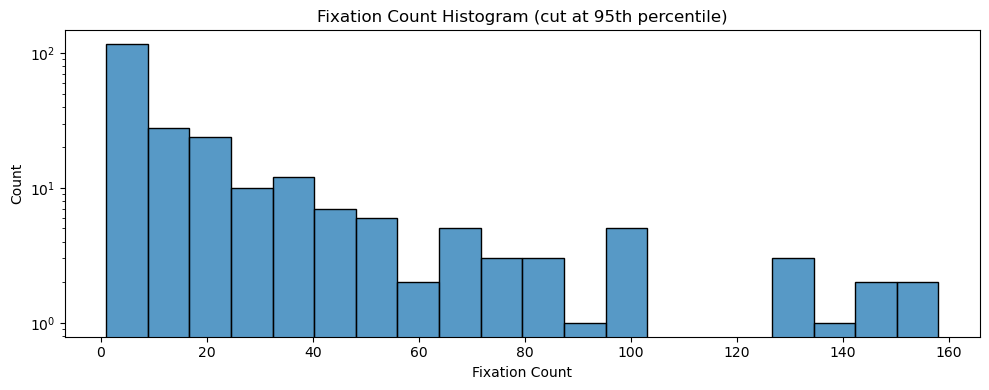

In [14]:
def plot_fixation_count_histogram(data):
    data = data.copy()
    data = data.groupby(["SequenceId", "InstanceId", "LabelClass", "Lifetime_ns", "MeanDistanceFromLast_px"]).agg(
        FixationCount=("FixationDuration_ns", "count")
    ).reset_index()

    # Remove outliers
    fixation_threshold = data["FixationCount"].quantile(0.95)
    data = data[data["FixationCount"] < fixation_threshold]

    # Plot the histogram
    plt.figure(figsize=(10, 4))
    sns.histplot(data["FixationCount"], bins=20)
    plt.title("Fixation Count Histogram (cut at 95th percentile)")
    plt.xlabel("Fixation Count")
    plt.ylabel("Count")
    plt.yscale("log")
    plt.tight_layout()
    plt.show()

# Call the function to plot the histogram
plot_fixation_count_histogram(merged_data_with_fixation)

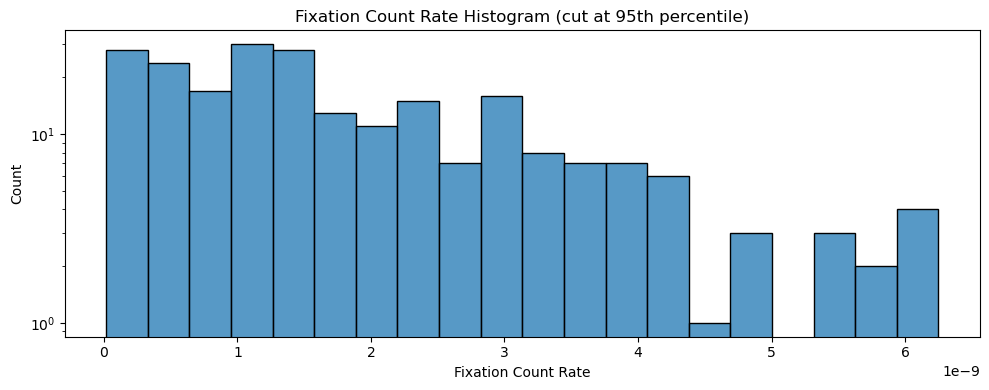

In [15]:
def plot_fixation_count_rate_histogram(data):
    data = data.copy()
    data = data.groupby(["SequenceId", "InstanceId", "LabelClass", "Lifetime_ns", "MeanDistanceFromLast_px"]).agg(
        FixationCount=("FixationDuration_ns", "count"),
    ).reset_index()
    data["FixationCountRate"] = data["FixationCount"] / data["Lifetime_ns"]

    # Remove outliers
    fixation_rate_threshold = data["FixationCountRate"].quantile(0.95)
    data = data[data["FixationCountRate"] < fixation_rate_threshold]

    # Plot the histogram
    plt.figure(figsize=(10, 4))
    sns.histplot(data["FixationCountRate"], bins=20)
    plt.title("Fixation Count Rate Histogram (cut at 95th percentile)")
    plt.xlabel("Fixation Count Rate")
    plt.ylabel("Count")
    plt.yscale("log")
    plt.tight_layout()
    plt.show()

# Call the function to plot the histogram
plot_fixation_count_rate_histogram(merged_data_with_fixation)

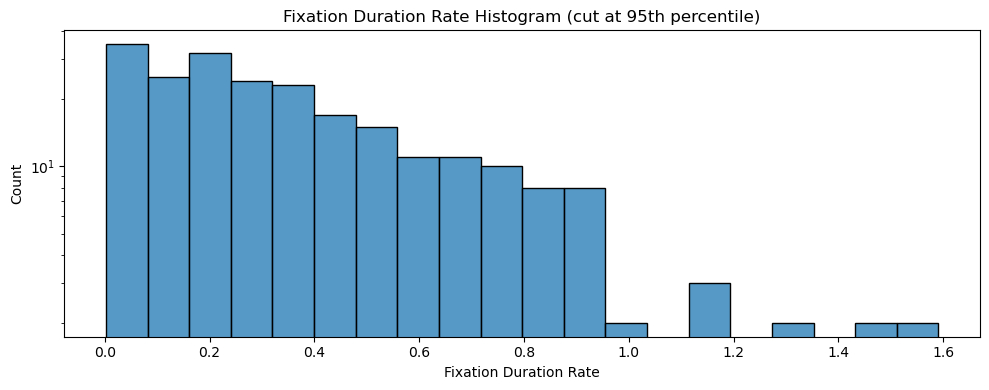

In [16]:
def plot_fixation_duration_rate_histogram(data):
    data = data.copy()
    data = data.groupby(["SequenceId", "InstanceId", "LabelClass", "Lifetime_ns", "MeanDistanceFromLast_px"]).agg(
        FixationSumDuration_ns=("FixationDuration_ns", "sum"),
    ).reset_index()
    data["FixationDurationRate"] = data["FixationSumDuration_ns"] / data["Lifetime_ns"]

    # Remove outliers
    fixation_rate_threshold = data["FixationDurationRate"].quantile(0.95)
    data = data[data["FixationDurationRate"] < fixation_rate_threshold]

    # Plot the histogram
    plt.figure(figsize=(10, 4))
    sns.histplot(data["FixationDurationRate"], bins=20)
    plt.title("Fixation Duration Rate Histogram (cut at 95th percentile)")
    plt.xlabel("Fixation Duration Rate")
    plt.ylabel("Count")
    plt.yscale("log")
    plt.tight_layout()
    plt.show()

# Call the function to plot the histogram
plot_fixation_duration_rate_histogram(merged_data_with_fixation)

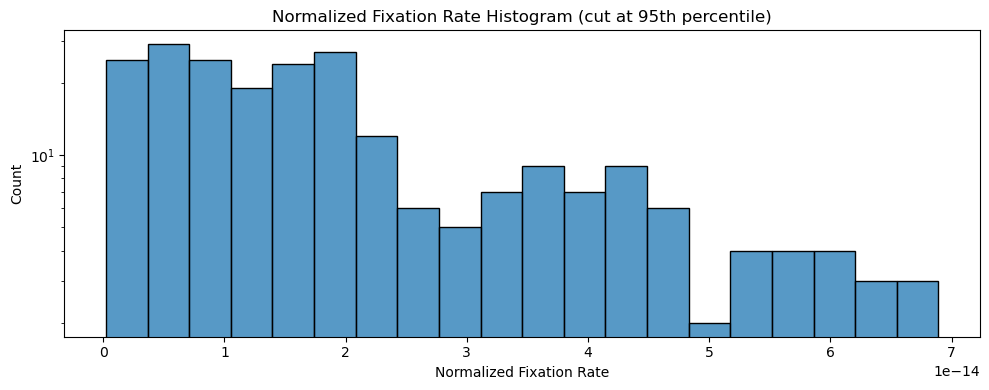

In [17]:
def plot_normalized_fixation_rate_histogram(
    data,
):
    data = data.copy()
    data = data.groupby(["SequenceId", "InstanceId", "LabelClass", "Lifetime_ns", "MeanDistanceFromLast_px"]).agg(
        FixationCount=("FixationDuration_ns", "count"),
        MeanArea_px2=("Area_px2", "mean"),
    ).reset_index()
    data["NormalizedFixationRate"] = data["FixationCount"] / (data["Lifetime_ns"] * data["MeanArea_px2"])

    # Remove outliers
    fixation_threshold = data["NormalizedFixationRate"].quantile(0.95)
    data = data[data["NormalizedFixationRate"] < fixation_threshold]

    # Plot the histogram
    plt.figure(figsize=(10, 4))
    sns.histplot(data["NormalizedFixationRate"], bins=20)
    plt.title("Normalized Fixation Rate Histogram (cut at 95th percentile)")
    plt.xlabel("Normalized Fixation Rate")
    plt.ylabel("Count")
    plt.yscale("log")
    plt.tight_layout()
    plt.show()

# Call the function to plot the histogram
plot_normalized_fixation_rate_histogram(merged_data_with_fixation)

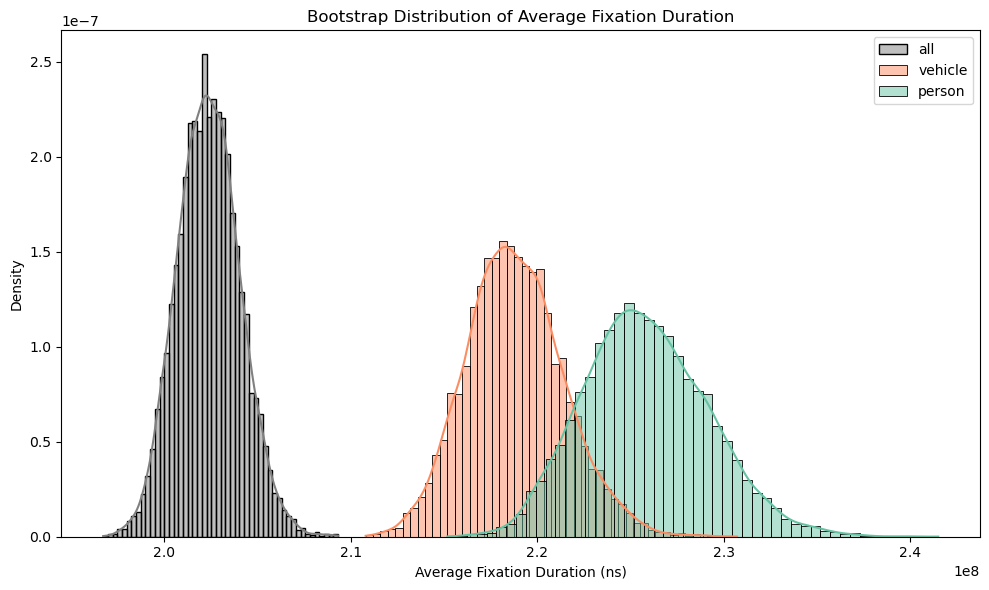

All objects: 202 ms
Vehicle objects: 219 ms, increase of 16 ms (8.12%)
Person objects: 226 ms, increase of 23 ms (11.59%)


In [22]:
def bootstrap_fixation_duration(
    fixation_data, merged_data, n_bootstrap=10_000
):
    """
    Perform bootstrapping for fixation durations for vehicle and person objects.

    Args:
        fixation_data (pd.DataFrame): The fixation data.
        merged_data (pd.DataFrame): The merged data.
        n_bootstrap (int): Number of bootstrap samples.
    """
    # Prepare data classes
    fixation_data = fixation_data.copy()
    merged_data = merged_data.copy()
    all_data = fixation_data["Duration_ns"].dropna()
    vehicle_data = merged_data[merged_data["LabelClass"] == "vehicle"][
        "FixationDuration_ns"
    ].dropna()
    person_data = merged_data[merged_data["LabelClass"] == "person"][
        "FixationDuration_ns"
    ].dropna()

    n_samples = max(len(vehicle_data), len(person_data))

    # Perform bootstrapping
    all_bootstrap_means = bootstrap(
        data=all_data,
        aggregation_function=np.mean,
        n_bootstrap=n_bootstrap,
        n_samples=n_samples,
        seed=SEED,
    )
    vehicle_bootstrap_means = bootstrap(
        data=vehicle_data,
        aggregation_function=np.mean,
        n_bootstrap=n_bootstrap,
        seed=SEED,
    )
    person_bootstrap_means = bootstrap(
        data=person_data,
        aggregation_function=np.mean,
        n_bootstrap=n_bootstrap,
        seed=SEED,
    )

    # Plot the distributions of bootstrapped means
    plt.figure(figsize=(10, 6))
    colors = sns.color_palette("Set2", n_colors=2)
    sns.histplot(
        all_bootstrap_means,
        bins=50,
        color="gray",
        label="all",
        kde=True,
        stat="density",
    )
    sns.histplot(
        vehicle_bootstrap_means,
        bins=50,
        color=colors[1],
        label="vehicle",
        kde=True,
        stat="density",
    )
    sns.histplot(
        person_bootstrap_means,
        bins=50,
        color=colors[0],
        label="person",
        kde=True,
        stat="density",
    )

    plt.title("Bootstrap Distribution of Average Fixation Duration")
    plt.xlabel("Average Fixation Duration (ns)")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Print mean of bootstrapped means
    print(f"All objects: {np.mean(all_bootstrap_means) / N_NSEC_IN_MSEC:.0f} ms")
    print(f"Vehicle objects: {np.mean(vehicle_bootstrap_means) / N_NSEC_IN_MSEC:.0f} ms, increase of {(np.mean(vehicle_bootstrap_means) - np.mean(all_bootstrap_means)) / N_NSEC_IN_MSEC:.0f} ms ({(np.mean(vehicle_bootstrap_means) - np.mean(all_bootstrap_means)) / np.mean(all_bootstrap_means) * 100:.2f}%)")
    print(f"Person objects: {np.mean(person_bootstrap_means) / N_NSEC_IN_MSEC:.0f} ms, increase of {(np.mean(person_bootstrap_means) - np.mean(all_bootstrap_means)) / N_NSEC_IN_MSEC:.0f} ms ({(np.mean(person_bootstrap_means) - np.mean(all_bootstrap_means)) / np.mean(all_bootstrap_means) * 100:.2f}%)")


bootstrap_fixation_duration(
    merged_data=merged_data_with_fixation, fixation_data=fixation_data
)

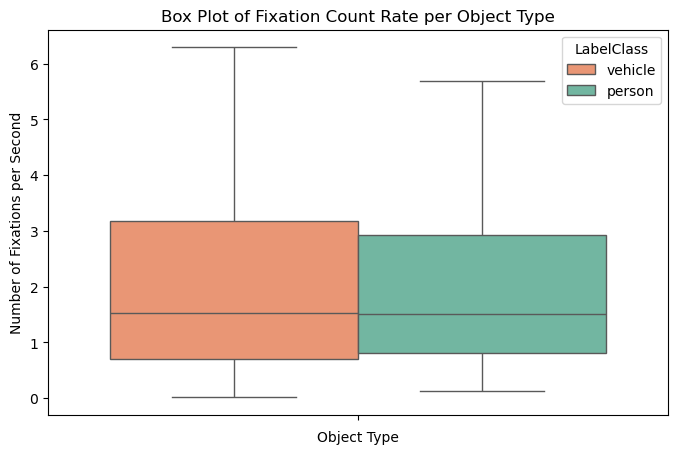

In [23]:
def plot_object_fixation_rate_count(
    data: pd.DataFrame,
):
    # Get object fixation count
    data = data.copy()
    data = data.groupby(["SequenceId", "InstanceId", "LabelClass", "Lifetime_ns", "MeanDistanceFromLast_px"]).agg(
        FixationCount=("FixationDuration_ns", "count")
    ).reset_index()
    data["FixationCountRate"] = data["FixationCount"] / data["Lifetime_ns"]
    data = data.replace([np.inf, -np.inf], np.nan).dropna(subset=["FixationCountRate"])

    # Rescale x-axis
    data["FixationCountRate"] = data["FixationCountRate"] * N_NSEC_IN_SEC
    
    # Plot the box plot
    colors = sns.color_palette("Set2", n_colors=len(data["LabelClass"].unique()))[::-1]
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=data, hue="LabelClass", y="FixationCountRate", palette=colors, showfliers=False)
    plt.title("Box Plot of Fixation Count Rate per Object Type")
    plt.xlabel("Object Type")
    plt.ylabel("Number of Fixations per Second")
    plt.show()

plot_object_fixation_rate_count(data=merged_data_with_fixation)

In [24]:
median_object_area = object_data["Area_px2"].median()
print(f"Median object area: {median_object_area:.2f} px^2")

Median object area: 85155.67 px^2


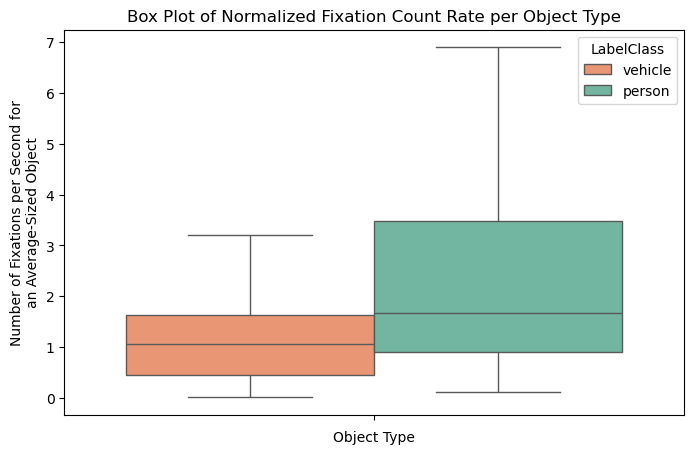

In [25]:
def plot_normalized_object_fixation_rate_count(
    data: pd.DataFrame,
    median_object_area: float,
):
    # Get normalized object fixation count
    data = data.copy()
    data = data.groupby(["SequenceId", "InstanceId", "LabelClass", "Lifetime_ns", "MeanDistanceFromLast_px"]).agg(
        FixationCount=("FixationDuration_ns", "count"),
        MeanArea_px2=("Area_px2", "mean"),
    ).reset_index()
    data["NormalizedFixationCountRate"] = data["FixationCount"] / (data["Lifetime_ns"] * data["MeanArea_px2"])
    data = data.replace([np.inf, -np.inf], np.nan).dropna()

    # Rescale x-axis
    data["NormalizedFixationCountRate"] = data["NormalizedFixationCountRate"] * median_object_area * N_NSEC_IN_SEC
    
    # Plot the box plot
    colors = sns.color_palette("Set2", n_colors=len(data["LabelClass"].unique()))[::-1]
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=data, hue="LabelClass", y="NormalizedFixationCountRate", palette=colors, showfliers=False)
    plt.title("Box Plot of Normalized Fixation Count Rate per Object Type")
    plt.xlabel("Object Type")
    plt.ylabel("Number of Fixations per Second for\nan Average-Sized Object")
    plt.show()

plot_normalized_object_fixation_rate_count(data=merged_data_with_fixation, median_object_area=median_object_area)

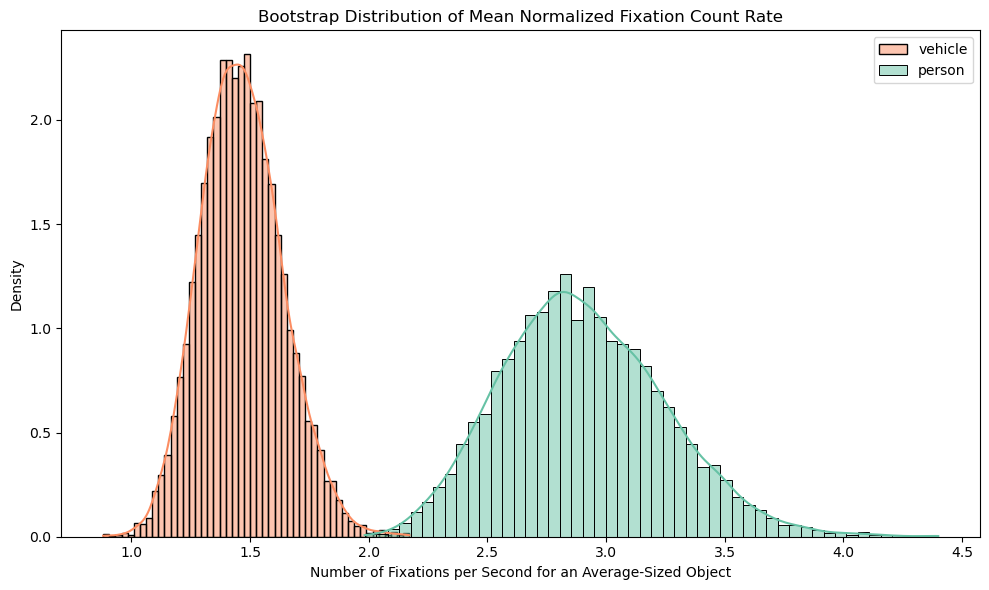

Number of fixations per second for an average-sized object:
	Null model: 0.49 #/s
	Vehicle objects: 1.47 #/s, increase of 0.98 #/s
	Person objects: 2.90 #/s, increase of 2.41 #/s


In [26]:
def bootstrap_normalized_fixation_count_rate_mean(
        merged_data: pd.DataFrame,
        fixation_data: pd.DataFrame,
        median_object_area: float,
        n_bootstrap: int = 10_000,
    ):
    """
    Perform bootstrapping for the mean of normalized fixation count rates for vehicles and people.

    Args:
        merged_data (pd.DataFrame): The merged data with fixation information.
        fixation_data (pd.DataFrame): The fixation data.
        n_bootstrap (int): Number of bootstrap samples.
    """
    # Calculate normalized fixation rate
    merged_data = merged_data.groupby(
        ["SequenceId", "InstanceId", "LabelClass", "Lifetime_ns", "MeanDistanceFromLast_px"]
    ).agg(
        FixationCount=("FixationDuration_ns", "count"),
        MeanArea_px2=("Area_px2", "mean"),
    ).reset_index()
    fixation_data = fixation_data.groupby("SequenceId")["Duration_ns"].count().reset_index().rename(columns={"Duration_ns": "FixationCount"})

    merged_data["NormalizedFixationCountRate"] = merged_data["FixationCount"] / (merged_data["Lifetime_ns"] * merged_data["MeanArea_px2"])
    merged_data = merged_data.replace([np.inf, -np.inf], np.nan).dropna()
    fixation_data["NormalizedFixationCountRate"] = fixation_data["FixationCount"] / (MAX_TIME_SINCE_START_SEC * N_NSEC_IN_SEC * RAW_GAZE_FRAME_WIDTH * RAW_GAZE_FRAME_HEIGHT)
    fixation_data = fixation_data.replace([np.inf, -np.inf], np.nan).dropna()

    # Filter data for vehicles and person
    vehicle_data = merged_data[merged_data["LabelClass"] == "vehicle"]["NormalizedFixationCountRate"].dropna()
    person_data = merged_data[merged_data["LabelClass"] == "person"]["NormalizedFixationCountRate"].dropna()

    # Perform bootstrapping
    all_bootstrap_means = bootstrap(
        data=fixation_data["NormalizedFixationCountRate"],
        aggregation_function=np.mean,
        n_bootstrap=n_bootstrap,
        seed=SEED,
    )
    vehicle_bootstrap_means = bootstrap(
        data=vehicle_data,
        aggregation_function=np.mean,
        n_bootstrap=n_bootstrap,
        seed=SEED,
    )
    person_bootstrap_means = bootstrap(
        data=person_data,
        aggregation_function=np.mean,
        n_bootstrap=n_bootstrap,
        seed=SEED,
    )

    # Rescale x-axis
    all_bootstrap_means *= median_object_area * N_NSEC_IN_SEC
    vehicle_bootstrap_means *= median_object_area * N_NSEC_IN_SEC
    person_bootstrap_means *= median_object_area * N_NSEC_IN_SEC

    # Plot the distributions of bootstrapped means
    plt.figure(figsize=(10, 6))
    colors = sns.color_palette("Set2", n_colors=2)
    sns.histplot(
        vehicle_bootstrap_means,
        bins=50,
        color=colors[1],
        label="vehicle",
        kde=True,
        stat="density",
    )
    sns.histplot(
        person_bootstrap_means,
        bins=50,
        color=colors[0],
        label="person",
        kde=True,
        stat="density",
    )

    plt.title("Bootstrap Distribution of Mean Normalized Fixation Count Rate")
    plt.xlabel("Number of Fixations per Second for an Average-Sized Object")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Print mean of bootstrapped means
    all_mean = np.mean(all_bootstrap_means)
    vehicle_mean = np.mean(vehicle_bootstrap_means)
    person_mean = np.mean(person_bootstrap_means)
    vehicle_diff = vehicle_mean - all_mean
    person_diff = person_mean - all_mean
    print("Number of fixations per second for an average-sized object:")
    print(f"\tNull model: {all_mean:.2f} #/s")
    print(f"\tVehicle objects: {vehicle_mean:.2f} #/s, increase of {vehicle_diff:.2f} #/s")
    print(f"\tPerson objects: {person_mean:.2f} #/s, increase of {person_diff:.2f} #/s")
    
bootstrap_normalized_fixation_count_rate_mean(
    merged_data=merged_data_with_fixation, 
    fixation_data=fixation_data, 
    median_object_area=median_object_area
)

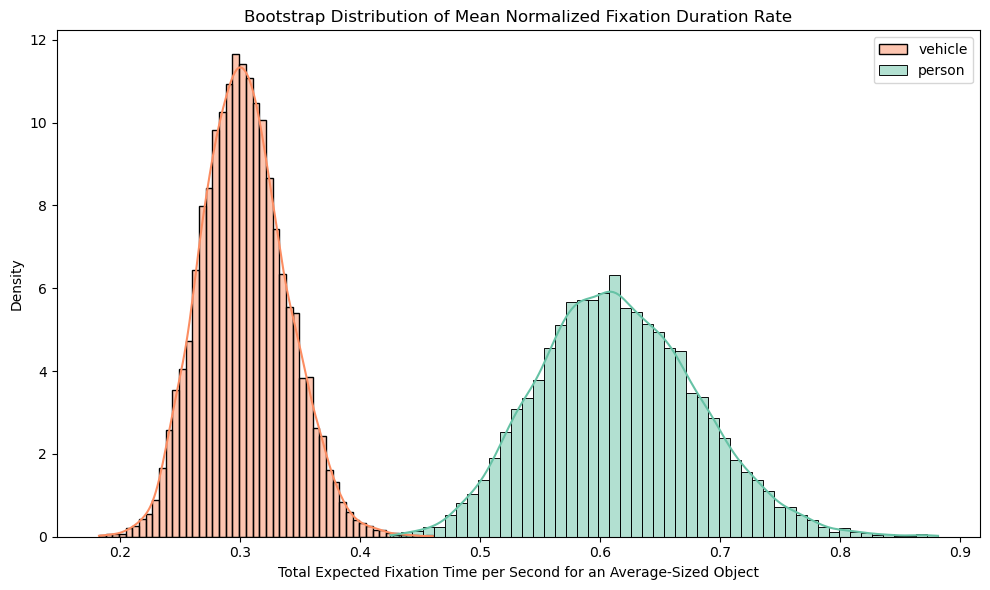

Total expected fixation time per second for an average-sized object:
	Null model: 0.10 s/s
	Vehicle objects: 0.30 s/s, increase of 0.20 s/s
	Person objects: 0.62 s/s, increase of 0.52 s/s


In [27]:
# TODO: update legends and etc
def bootstrap_normalized_fixation_duration_rate_mean(
        fixation_data: pd.DataFrame,
        merged_data: pd.DataFrame,
        median_object_area: float,
        n_bootstrap: int = 10_000,
    ):
    """
    Perform bootstrapping for the mean of normalized fixation duration rates for vehicle and person objects.

    Args:
        fixation_data (pd.DataFrame): The fixation data.
        merged_data (pd.DataFrame): The merged data with fixation information.
        n_bootstrap (int): Number of bootstrap samples.
    """
    # Calculate normalized fixation rate
    merged_data = merged_data.groupby(
        ["SequenceId", "InstanceId", "LabelClass", "Lifetime_ns", "MeanDistanceFromLast_px"]
    ).agg(
        FixationSumDuration_ns=("FixationDuration_ns", "sum"),
        MeanArea_px2=("Area_px2", "mean"),
    ).reset_index()
    fixation_data = fixation_data.groupby("SequenceId")["Duration_ns"].sum().reset_index().rename(columns={"Duration_ns": "FixationSumDuration_ns"})

    merged_data["NormalizedFixationDurationRate"] = merged_data["FixationSumDuration_ns"] / (merged_data["Lifetime_ns"] * merged_data["MeanArea_px2"])
    merged_data = merged_data.replace([np.inf, -np.inf], np.nan).dropna()
    fixation_data["NormalizedFixationDurationRate"] = fixation_data["FixationSumDuration_ns"] / (MAX_TIME_SINCE_START_SEC * N_NSEC_IN_SEC * RAW_GAZE_FRAME_WIDTH * RAW_GAZE_FRAME_HEIGHT)
    fixation_data = fixation_data.replace([np.inf, -np.inf], np.nan).dropna()

    # Filter data for vehicles and person
    vehicle_data = merged_data[merged_data["LabelClass"] == "vehicle"]["NormalizedFixationDurationRate"].dropna()
    person_data = merged_data[merged_data["LabelClass"] == "person"]["NormalizedFixationDurationRate"].dropna()

    # Perform bootstrapping
    all_bootstrap_means = bootstrap(
        data=fixation_data["NormalizedFixationDurationRate"],
        aggregation_function=np.mean,
        n_bootstrap=n_bootstrap,
        seed=SEED,
    )
    vehicle_bootstrap_means = bootstrap(
        data=vehicle_data,
        aggregation_function=np.mean,
        n_bootstrap=n_bootstrap,
        seed=SEED,
    )
    person_bootstrap_means = bootstrap(
        data=person_data,
        aggregation_function=np.mean,
        n_bootstrap=n_bootstrap,
        seed=SEED,
    )

    # Rescale x-axis
    all_bootstrap_means *= median_object_area
    vehicle_bootstrap_means *= median_object_area
    person_bootstrap_means *= median_object_area

    # Plot the distributions of bootstrapped means
    plt.figure(figsize=(10, 6))
    colors = sns.color_palette("Set2", n_colors=2)
    sns.histplot(
        vehicle_bootstrap_means,
        bins=50,
        color=colors[1],
        label="vehicle",
        kde=True,
        stat="density",
    )
    sns.histplot(
        person_bootstrap_means,
        bins=50,
        color=colors[0],
        label="person",
        kde=True,
        stat="density",
    )

    plt.title("Bootstrap Distribution of Mean Normalized Fixation Duration Rate")
    plt.xlabel("Total Expected Fixation Time per Second for an Average-Sized Object")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Print mean of bootstrapped means
    all_mean = np.mean(all_bootstrap_means)
    vehicle_mean = np.mean(vehicle_bootstrap_means)
    person_mean = np.mean(person_bootstrap_means)
    vehicle_diff = vehicle_mean - all_mean
    person_diff = person_mean - all_mean
    print("Total expected fixation time per second for an average-sized object:")
    print(f"\tNull model: {all_mean:.2f} s/s")
    print(f"\tVehicle objects: {vehicle_mean:.2f} s/s, increase of {vehicle_diff:.2f} s/s")
    print(f"\tPerson objects: {person_mean:.2f} s/s, increase of {person_diff:.2f} s/s")
    
bootstrap_normalized_fixation_duration_rate_mean(
    merged_data=merged_data_with_fixation, 
    fixation_data=fixation_data, 
    median_object_area=median_object_area
)

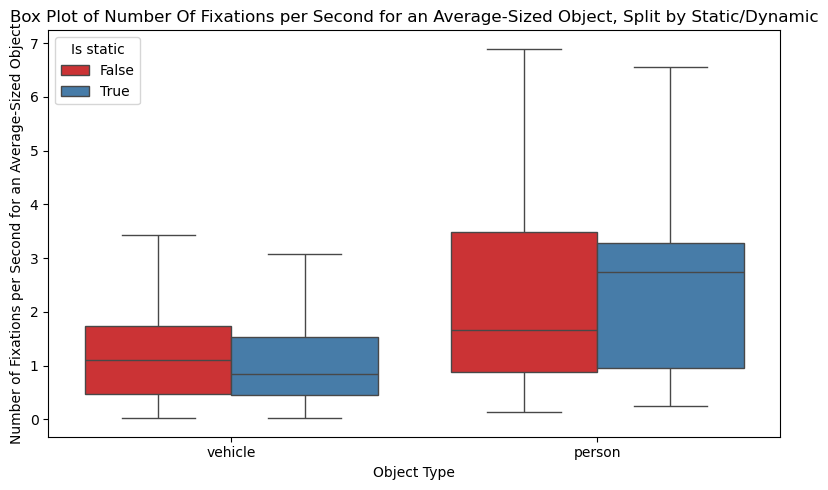

Static count:


LabelClass
person     12
vehicle    18
dtype: int64

Dynamic count:


LabelClass
person     152
vehicle     61
dtype: int64

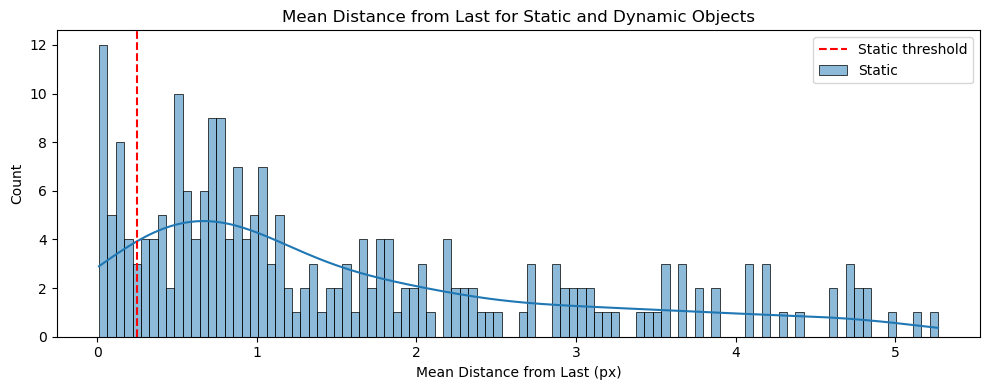

In [28]:
def plot_static_dynamic_distributions(
    data: pd.DataFrame,
    median_object_area: float,
    static_threshold: float = 0.25,
):
    # Get normalized object fixation count
    data = data.copy()
    data = data.groupby(["SequenceId", "InstanceId", "LabelClass", "Lifetime_ns", "MeanDistanceFromLast_px"]).agg(
        FixationCount=("FixationDuration_ns", "count"),
        MeanArea_px2=("Area_px2", "mean"),
    ).reset_index()
    data["NormalizedFixationRate"] = data["FixationCount"] / (data["Lifetime_ns"] * data["MeanArea_px2"])
    data = data.replace([np.inf, -np.inf], np.nan).dropna()

    # Create a new column for static/dynamic classification
    data["Static"] = data["MeanDistanceFromLast_px"] < static_threshold

    # Rescale x-axis
    data["NormalizedFixationRate"] = data["NormalizedFixationRate"] * median_object_area * N_NSEC_IN_SEC

    # Plot the box plot
    plt.figure(figsize=(8, 5))
    sns.boxplot(
        data=data,
        x="LabelClass",
        y="NormalizedFixationRate",
        hue="Static",
        palette="Set1",
        showfliers=False
    )
    plt.title("Box Plot of Number Of Fixations per Second for an Average-Sized Object, Split by Static/Dynamic")
    plt.xlabel("Object Type")
    plt.ylabel("Number of Fixations per Second for an Average-Sized Object")
    plt.legend(title="Is static")
    plt.tight_layout()
    plt.show()

    # Count number of static and dynamic objects for each label class
    static_data = data[data["Static"]]
    dynamic_data = data[~data["Static"]]
    static_count = static_data.groupby("LabelClass").size()
    dynamic_count = dynamic_data.groupby("LabelClass").size()
    print("Static count:")
    display(static_count)
    print("Dynamic count:")
    display(dynamic_count)

    # Plot the histogram of mean distance from last for static and dynamic
    data = data[data["MeanDistanceFromLast_px"] < data["MeanDistanceFromLast_px"].quantile(0.95)]
    plt.figure(figsize=(10, 4))
    sns.histplot(data=data, x="MeanDistanceFromLast_px", bins=100, kde=True, label="Static")
    plt.axvline(static_threshold, color='r', linestyle='--', label='Static threshold')
    plt.title("Mean Distance from Last for Static and Dynamic Objects")
    plt.xlabel("Mean Distance from Last (px)")
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_static_dynamic_distributions(
    data=merged_data_with_fixation,
    median_object_area=median_object_area,
)

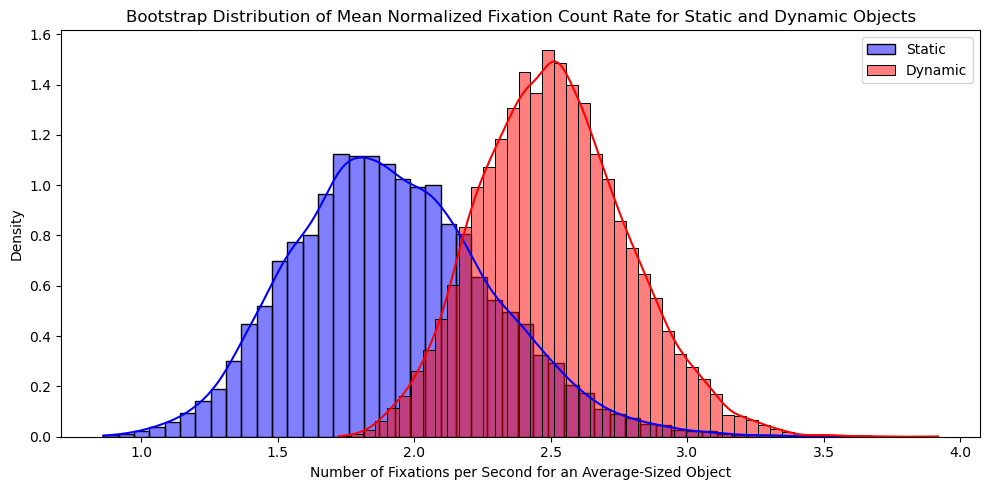

Number of fixations per second for an average-sized object:
	Static objects: 1.92 #/s
	Dynamic objects: 2.51 #/s, increase of 0.59 #/s (31.00%)


In [29]:
def plot_static_dynamic_distributions_with_bootstrapping(
    data: pd.DataFrame,
    median_object_area: float,
    static_threshold: float = 0.25,
    n_bootstrap: int = 10_000,
):
    """
    Modified function to plot static/dynamic distributions with bootstrapping for mean of Normalized Fixation Rate.

    Args:
        data (pd.DataFrame): The merged dataset containing fixation data.
        static_threshold (float): Threshold for classifying static vs dynamic.
        n_bootstrap (int): Number of bootstrap iterations.
    """
    # Get normalized object fixation count
    data = data.copy()
    data = (
        data.groupby(
            [
                "SequenceId",
                "InstanceId",
                "LabelClass",
                "Lifetime_ns",
                "MeanDistanceFromLast_px",
            ]
        )
        .agg(
            FixationCount=("FixationDuration_ns", "count"),
            MeanArea_px2=("Area_px2", "mean"),
        )
        .reset_index()
    )
    data["NormalizedFixationCountRate"] = data["FixationCount"] / (
        data["Lifetime_ns"] * data["MeanArea_px2"]
    )
    data = data.replace([np.inf, -np.inf], np.nan).dropna()

    # Create a new column for static/dynamic classification
    data["Static"] = data["MeanDistanceFromLast_px"] < static_threshold

    # Separate static and dynamic data
    static_data = data[data["Static"]]["NormalizedFixationCountRate"]
    dynamic_data = data[~data["Static"]]["NormalizedFixationCountRate"]

    # Perform bootstrapping to get distributions of means
    static_means = bootstrap(
        data=static_data,
        aggregation_function=np.mean, 
        n_bootstrap=n_bootstrap, 
        seed=SEED
    )
    dynamic_means = bootstrap(
        dynamic_data, 
        aggregation_function=np.mean,
        n_bootstrap=n_bootstrap, 
        seed=SEED
    )

    # Rescale x-axis
    static_means *= median_object_area * N_NSEC_IN_SEC
    dynamic_means *= median_object_area * N_NSEC_IN_SEC

    # Plot histogram of the bootstrapped means
    plt.figure(figsize=(10, 5))
    sns.histplot(
        static_means, bins=50, color="blue", label="Static", kde=True, stat="density"
    )
    sns.histplot(
        dynamic_means, bins=50, color="red", label="Dynamic", kde=True, stat="density"
    )

    plt.title("Bootstrap Distribution of Mean Normalized Fixation Count Rate for Static and Dynamic Objects")
    plt.xlabel("Number of Fixations per Second for an Average-Sized Object")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Print the mean of the bootstrapped means
    static_mean = np.mean(static_means)
    dynamic_mean = np.mean(dynamic_means)
    dynamic_diff = dynamic_mean - static_mean
    dynamic_percent_diff = (dynamic_mean - static_mean) / static_mean * 100
    print("Number of fixations per second for an average-sized object:")
    print(f"\tStatic objects: {static_mean:.2f} #/s")
    print(f"\tDynamic objects: {dynamic_mean:.2f} #/s, increase of {dynamic_diff:.2f} #/s ({dynamic_percent_diff:.2f}%)")


# Call the modified function with the dataset
plot_static_dynamic_distributions_with_bootstrapping(
    data=merged_data_with_fixation,
    median_object_area=median_object_area
)

## Analysis II

In [30]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from scipy import stats
from sklearn.decomposition import PCA
from matplotlib.colors import LogNorm
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
import shap

c:\Users\arnau\anaconda3\envs\pdm\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [31]:
def split_object_into_time_intervals(
        data: pd.DataFrame, 
        interval_ns: float = 1 * N_NSEC_IN_SEC, # 1 second
        min_lifetime_ns: float = 1 / FPS * N_NSEC_IN_SEC, # 1 frame
        static_threshold: float = 0.1,
        remove_object_without_fixation: bool = False,
        ):
    """
    Split each object into multiple entries, each representing a fixed time period (e.g., 1 second).

    Args:
        data (pd.DataFrame): Merged dataset containing object and fixation information.
        interval_ns (float): Time interval in nanoseconds (default 1 second = 1e9 ns).

    Returns:
        pd.DataFrame: Expanded dataset with objects split into multiple time intervals.
    """
    # Get interval ID for each object and aggregate by it
    data = data.copy()
    data["IntervalId"] = data["TimeSinceAppearance_ns"].apply(lambda x: int(x // interval_ns))
    
    # Group by interval and aggregate data
    data = data.groupby(["SequenceId", "InstanceId", "IntervalId"]).agg(
        StartFrameId=("FrameId", "first"),
        EndFrameId=("FrameId", "last"),
        LabelString=("LabelStr", "first"),
        LabelClass=("LabelClass", "first"),
        CenterX_px=("CenterX_px", "mean"),
        CenterY_px=("CenterY_px", "mean"),
        Width_px=("Width_px", "mean"),
        Height_px=("Height_px", "mean"),
        Area_px2=("Area_px2", "mean"),
        DistanceFromLast_px=("DistanceFromLast_px", "mean"),
        AngleFromLast_deg=("AngleFromLast_deg", "mean"),
        DepthLevel=("DepthLevel", "mean"),
        DistanceFromCenter_px=("DistanceFromCenter_px", "mean"),
        StartTimeSinceStart_ns=("TimeSinceStart_ns", "first"),
        EndTimeSinceStart_ns=("TimeSinceStart_ns", "last"),
        StartTimeSinceAppearance_ns=("TimeSinceAppearance_ns", "first"),
        EndTimeSinceAppearance_ns=("TimeSinceAppearance_ns", "last"),
        FixationCount=("FixationDuration_ns", "count"),
        FixationDuration_ns=("FixationDuration_ns", "mean"),
    ).reset_index()

    # Define lifetime and filter out objects with lifetime less than min_lifetime_ns
    data["Lifetime_ns"] = data["EndTimeSinceAppearance_ns"] - data["StartTimeSinceAppearance_ns"]
    data = data[data["Lifetime_ns"] >= min_lifetime_ns]

    # Get LabelId
    data["IsVehicle"] = (data["LabelClass"] == "vehicle").astype(int)
    data["IsPerson"] = (data["LabelClass"] == "person").astype(int)

    # Get sine and cosine components of angle
    data["AngleSin"] = np.sin(np.radians(data["AngleFromLast_deg"]))
    data["AngleCos"] = np.cos(np.radians(data["AngleFromLast_deg"]))

    # Get sqrt of area
    data["SqrtArea_px"] = np.sqrt(data["Area_px2"])

    # Get normalized fixation rates
    median_object_area = data["Area_px2"].median()
    data["NormalizedFixationCountRate"] = data["FixationCount"] / (data["Lifetime_ns"] * data["Area_px2"])
    data["NormalizedFixationCountRate"] = data["NormalizedFixationCountRate"] * median_object_area * N_NSEC_IN_SEC
    data["LogNormalizedFixationCountRate"] = np.log(data["NormalizedFixationCountRate"] + 1)
    data["SqrtNormalizedFixationCountRate"] = np.sqrt(data["NormalizedFixationCountRate"])

    # Create just appeared features
    data["JustAppeared"] = (data["StartTimeSinceStart_ns"] < 1 * N_NSEC_IN_SEC).astype(int)

    # Create static/dynamic features
    data["Static"] = (data["DistanceFromLast_px"] < static_threshold).astype(int)

    if remove_object_without_fixation:
        without_fixation = data["FixationCount"] == 0
        data = data[~without_fixation]
        print(f"✅ Removed {without_fixation.sum()} object(s) without fixations.")

    # Add interaction terms
    data['IsPerson_Depth'] = data['IsPerson'] * data['DepthLevel']
    data['IsPerson_DistanceFromLast'] = data['IsPerson'] * data['DistanceFromLast_px']
    
    return data

merged_data_by_interval = split_object_into_time_intervals(
    data=merged_data,
    remove_object_without_fixation = True,
)
merged_data_by_interval

✅ Removed 1062 object(s) without fixations.


,SequenceId,InstanceId,IntervalId,StartFrameId,EndFrameId,LabelString,LabelClass,CenterX_px,CenterY_px,Width_px,...,AngleSin,AngleCos,SqrtArea_px,NormalizedFixationCountRate,LogNormalizedFixationCountRate,SqrtNormalizedFixationCountRate,JustAppeared,Static,IsPerson_Depth,IsPerson_DistanceFromLast
0,1,0,0,0,24,car,vehicle,3344.927354,2487.208169,412.229947,...,0.390144,0.920754,402.564748,2.715465,1.312504,1.647867,1,1,0.0,0.0
1,1,0,1,25,49,car,vehicle,3345.331935,2488.477560,412.330284,...,0.479072,0.877776,401.629333,2.182503,1.157668,1.477330,0,1,0.0,0.0
2,1,0,2,50,74,car,vehicle,3345.373170,2487.603597,411.774636,...,-0.911857,0.410509,401.581061,3.274541,1.452677,1.809569,0,1,0.0,0.0
3,1,0,3,75,99,car,vehicle,3345.452880,2486.989151,412.435355,...,-0.178340,0.983969,402.268706,2.719463,1.313579,1.649080,0,1,0.0,0.0
4,1,0,4,100,124,car,vehicle,3345.226724,2486.342853,412.517299,...,-0.748795,0.662802,403.120946,4.332763,1.673870,2.081529,0,1,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3574,14,1,55,1375,1399,car,vehicle,3630.282997,2783.293273,694.959595,...,-0.571564,0.820558,639.591407,0.645449,0.498013,0.803398,0,1,0.0,0.0
3575,14,1,56,1400,1424,car,vehicle,3629.084712,2783.058994,695.882938,...,-0.025237,0.999681,640.109647,0.644404,0.497378,0.802748,0,1,0.0,0.0
3576,14,1,57,1425,1449,car,vehicle,3628.715422,2782.451398,695.171824,...,-0.071819,0.997418,639.893355,0.214947,0.194700,0.463623,0,1,0.0,0.0
3577,14,1,58,1450,1474,car,vehicle,3628.530476,2782.071706,696.938178,...,0.210350,0.977626,640.743025,0.428754,0.356803,0.654793,0,1,0.0,0.0


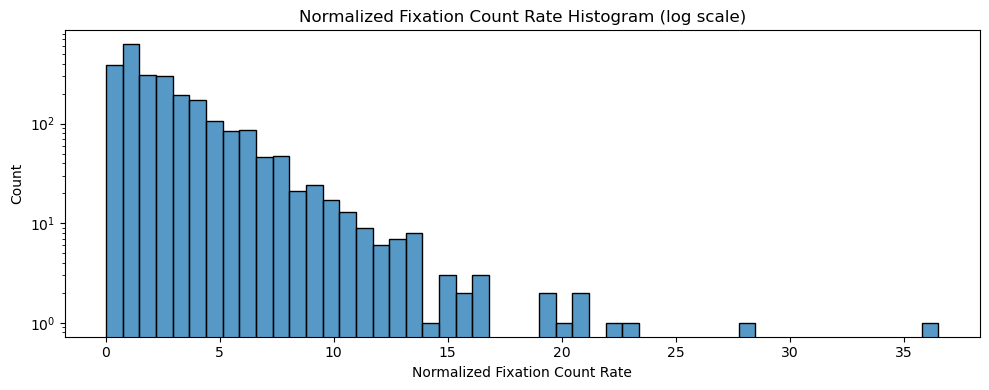

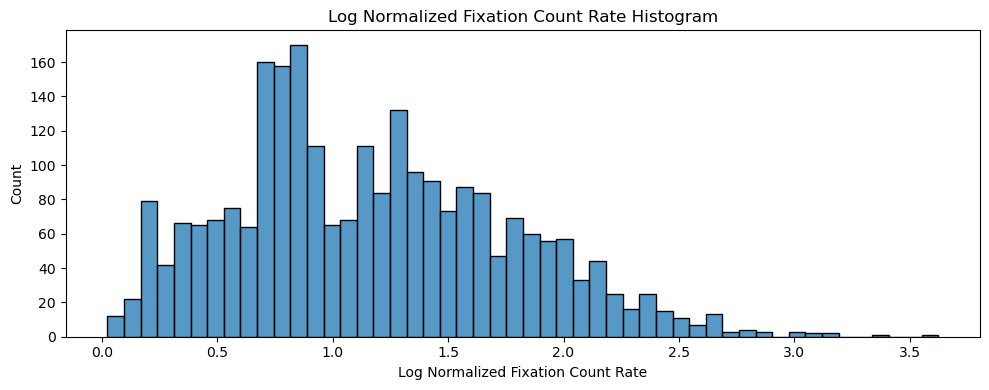

In [32]:
def plot_feature_histogram(
    data: pd.DataFrame,
    feature: str,
    feature_legend: str = None,
    n_bins: int = 50,
    log_scale: bool = False,
):
    plt.figure(figsize=(10, 4))
    sns.histplot(data[feature], bins=n_bins)
    plt.title(f"{feature_legend} Histogram{' (log scale)' if log_scale else ''}")
    plt.xlabel(feature_legend)
    plt.ylabel("Count")
    if log_scale:
        plt.yscale("log")
    plt.tight_layout()
    plt.show()

plot_feature_histogram(
    data=merged_data_by_interval, 
    feature="NormalizedFixationCountRate",
    feature_legend="Normalized Fixation Count Rate",
    log_scale=True
)
plot_feature_histogram(
    data=merged_data_by_interval, 
    feature="LogNormalizedFixationCountRate",
    feature_legend="Log Normalized Fixation Count Rate",
    log_scale=False,
)

In [33]:
input_predictor_columns = [
    "IsPerson",
    "DistanceFromLast_px",
    "DistanceFromCenter_px",
    "AngleSin",
    "AngleCos",
    "DepthLevel",
    "StartTimeSinceAppearance_ns",
]
input_predictor_labels = [
    "Is Person",
    "Speed (px/fr)",
    "Distance From Center (px)",
    "Angle Sin",
    "Angle Cos",
    "Depth Level",
    "Time Since Appearance (ns)",
]

interaction_predictor_columns = [
    "IsPerson_Depth",
    "IsPerson_DistanceFromLast",
]
interaction_predictor_labels = [
    "Is person * Depth",
    "Is person * Speed",
]

predictor_columns = input_predictor_columns + interaction_predictor_columns
predictor_labels = input_predictor_labels + interaction_predictor_labels

target_column = "LogNormalizedFixationCountRate"
target_label = "Log Normalized Fixation Count Rate"

In [34]:
def get_predictor_and_target_features(
    predictor_columns: List[str],
    target_column: str,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Get predictor and target features for the regression model.

    Args:
        predictor_columns (List[str]): List of predictor columns.
        target_column (str): Target column.

    Returns:
        np.ndarray: Predictor features.
        np.ndarray: Target features.
    """
    # Get columns and remove outliers
    Xy = merged_data_by_interval[predictor_columns + [target_column]].dropna()
    old_n_samples = Xy.shape[0]
    z_scores = np.abs(stats.zscore(Xy))
    Xy = Xy[(z_scores < 3).all(axis=1)]
    new_n_samples = Xy.shape[0]

    print(f"✅ Removed {old_n_samples - new_n_samples} outlier(s).")

    # Get X and y
    X = Xy[predictor_columns].values
    y_count = Xy[target_column].values

    # Normalize the data
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    print(f"✅ Loaded {X.shape[0]} samples and {X.shape[1]} features.")

    return X, y_count

X, y_count = get_predictor_and_target_features(
    predictor_columns=predictor_columns,
    target_column=target_column,
)

✅ Removed 107 outlier(s).
✅ Loaded 2373 samples and 9 features.


In [35]:
def get_input_predictor_features(
    X: np.ndarray,
    predictor_columns: List[str],
    input_predictor_columns: List[str],
) -> np.ndarray:
    column_indexes = [predictor_columns.index(column) for column in input_predictor_columns]
    X_input = X[:, column_indexes]

    return X_input

X_input = get_input_predictor_features(
    X=X,
    predictor_columns=predictor_columns,
    input_predictor_columns=input_predictor_columns,
)

PCA Loadings:
                                  PC1       PC2
Is Person                   0.462565 -0.077068
Speed (px/fr)               0.412420  0.048559
Distance From Center (px)  -0.050504  0.587369
Angle Sin                   0.059578 -0.148725
Angle Cos                  -0.227905  0.136626
Depth Level                -0.070677  0.680850
Time Since Appearance (ns) -0.321147  0.208773
Is person * Depth           0.450025  0.272580
Is person * Speed           0.497241  0.156434


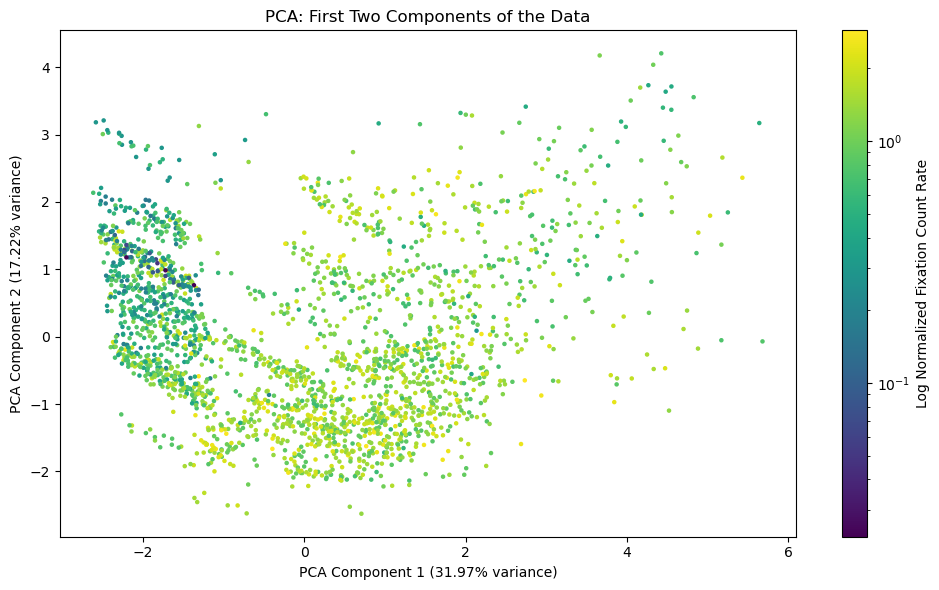

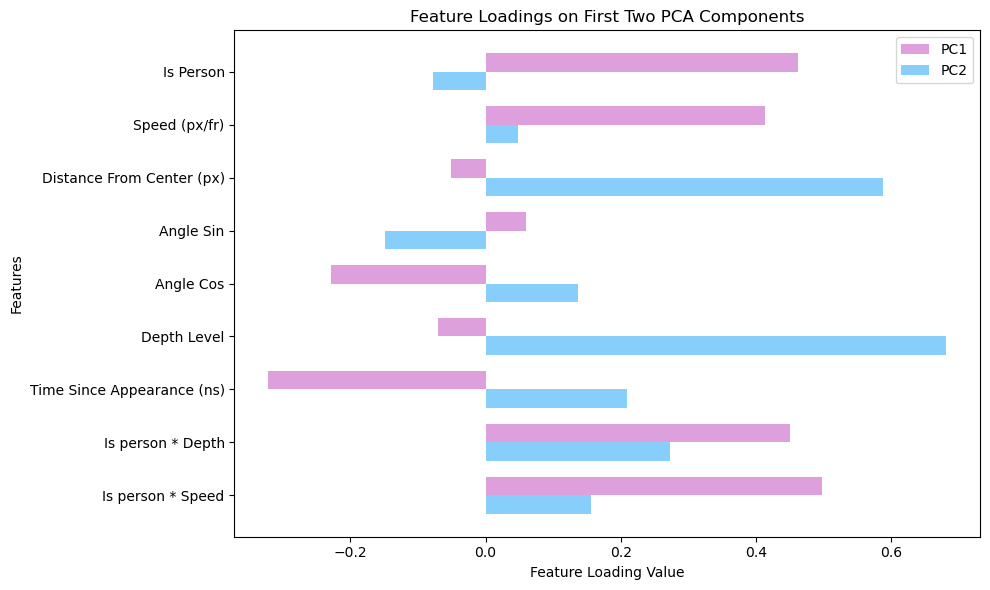

In [36]:
def plot_pca_analysis(
        X: np.ndarray, 
        y: np.ndarray, 
        feature_labels: list, 
        target_label: str,
        n_components: int = 2
) -> None:
    """
    Apply PCA, plot the first two components, and display feature loadings.

    Args:
        X (np.ndarray): Predictor features.
        y (np.ndarray): Target feature.
        feature_labels (list): List of feature names.
        target_label (str): Target feature name.
        n_components (int): Number of PCA components to plot.
    """
    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)

    # Get PCA loadings for the features
    loadings = pca.components_.T
    loadings_df = pd.DataFrame(loadings, columns=[f'PC{i+1}' for i in range(n_components)], index=feature_labels)
    print("PCA Loadings:\n", loadings_df)

    # Plot PCA scatter plot for the first two components
    plt.figure(figsize=(10, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', norm=LogNorm(), s=5)
    plt.colorbar(label=target_label)
    plt.xlabel(f"PCA Component 1 ({pca.explained_variance_ratio_[0]*100:.2f}% variance)")
    plt.ylabel(f"PCA Component 2 ({pca.explained_variance_ratio_[1]*100:.2f}% variance)")
    plt.title("PCA: First Two Components of the Data")
    plt.tight_layout()
    plt.show()

    # Plot the loadings of the features on the first two components
    n_features = len(loadings_df)
    index = np.arange(n_features)
    bar_width = 0.35
    plt.figure(figsize=(10, 6))
    plt.barh(index, loadings_df["PC1"], bar_width, color='plum', label='PC1')
    plt.barh(index + bar_width, loadings_df["PC2"], bar_width, color='lightskyblue', label='PC2')
    plt.xlabel("Feature Loading Value")
    plt.ylabel("Features")
    plt.yticks(index + bar_width / 2, loadings_df.index)
    plt.title("Feature Loadings on First Two PCA Components")
    plt.gca().invert_yaxis()
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_pca_analysis(
    X=X, 
    y=y_count, 
    feature_labels=predictor_labels,
    target_label=target_label, 
    n_components=2
)

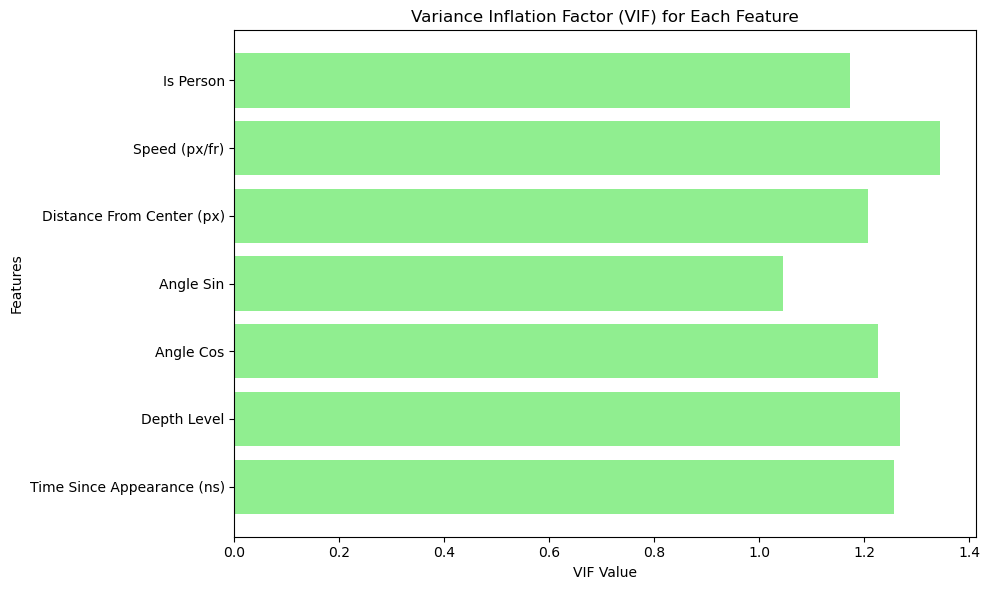

In [37]:
def plot_vif(
        X: np.ndarray, 
        predictor_labels: list,
        vif_threshold_low: float = 5,
        vif_threshold_high: float = 10,
) -> None:
    """
    Get Variance Inflation Factor (VIF) for each feature and plot it.

    Args:
        X (np.ndarray): Predictor features.
        predictor_columns (list): List of feature names.
    """
    # Calculate VIF for each feature
    vif = pd.DataFrame()
    vif["Feature"] = predictor_labels
    vif["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]

    # Plot VIF using a bar plot
    colors = vif["VIF"].apply(lambda x: 'lightgreen' if x < vif_threshold_low else ('sandybrown' if x < vif_threshold_high else 'lightcoral'))
    plt.figure(figsize=(10, 6))
    plt.barh(vif["Feature"], vif["VIF"], color=colors)
    plt.xlabel("VIF Value")
    plt.ylabel("Features")
    plt.title("Variance Inflation Factor (VIF) for Each Feature")
    plt.gca().invert_yaxis()  # Invert y-axis to show the largest VIF at the top
    plt.tight_layout()
    plt.show()

plot_vif(
    X=X_input, 
    predictor_labels=input_predictor_labels,
    )

In [38]:
# Add a constant to the features (required by statsmodels)
X_df = pd.DataFrame(X, columns=predictor_labels)
X_const = sm.add_constant(X_df)

# Model for Normalized Fixation Count Rate
model_count_sm = sm.OLS(y_count, X_const)
results_count = model_count_sm.fit()

# Print the summary to see the coefficients, p-values, and other statistics
print("Results for Normalized Fixation Count Rate:")
print(results_count.summary())

Results for Normalized Fixation Count Rate:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     90.39
Date:                Tue, 22 Oct 2024   Prob (F-statistic):          6.50e-145
Time:                        11:02:54   Log-Likelihood:                -1730.7
No. Observations:                2373   AIC:                             3481.
Df Residuals:                    2363   BIC:                             3539.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

In [39]:
def apply_gradient_boosting(X, y, test_size=0.2, random_state=42, n_estimators=100, learning_rate=0.1, max_depth=5):
    """
    Apply Gradient Boosting Regressor and return model, and predictions.

    Args:
        X (ndarray): Features.
        y (ndarray): Target variable.
        test_size (float): Proportion of the dataset to include in the test split.
        random_state (int): Random state for reproducibility.
        n_estimators (int): The number of boosting stages to be run.
        learning_rate (float): Shrinks the contribution of each tree.
        max_depth (int): The maximum depth of the individual regression estimators.

    Returns:
        gbr: The trained Gradient Boosting Regressor model.
        y_test: Actual values for the test set.
        y_pred: Predicted values for the test set.
    """
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Initialize and train the model
    gbr = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, random_state=random_state)
    gbr.fit(X_train, y_train)

    # Predict on the test set
    y_pred = gbr.predict(X_test)

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Print metrics
    print(f"Gradient Boosting MSE: {mse}")
    print(f"Gradient Boosting R²: {r2}")

    return gbr, y_test, y_pred

gbr, y_test, y_pred = apply_gradient_boosting(X, y_count)

Gradient Boosting MSE: 0.2124783392359036
Gradient Boosting R²: 0.3700815767573963


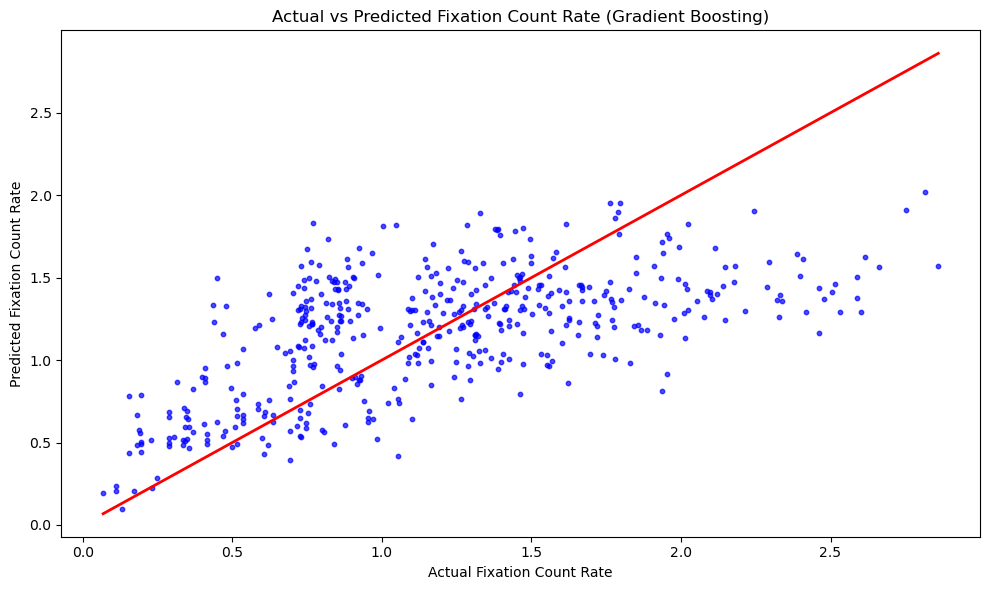

In [40]:
def plot_actual_vs_predicted(y_test, y_pred):
    """
    Plot actual vs predicted values.

    Args:
        y_test (ndarray): Actual values from the test set.
        y_pred (ndarray): Predicted values from the test set.
    """
    # Scatter plot of actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, s=10, color='blue', alpha=0.7)
    
    # Plot the line representing a perfect prediction
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)

    # Labels and title
    plt.xlabel("Actual Fixation Count Rate")
    plt.ylabel("Predicted Fixation Count Rate")
    plt.title("Actual vs Predicted Fixation Count Rate (Gradient Boosting)")
    
    # Show the plot
    plt.tight_layout()
    plt.show()

plot_actual_vs_predicted(y_test, y_pred)

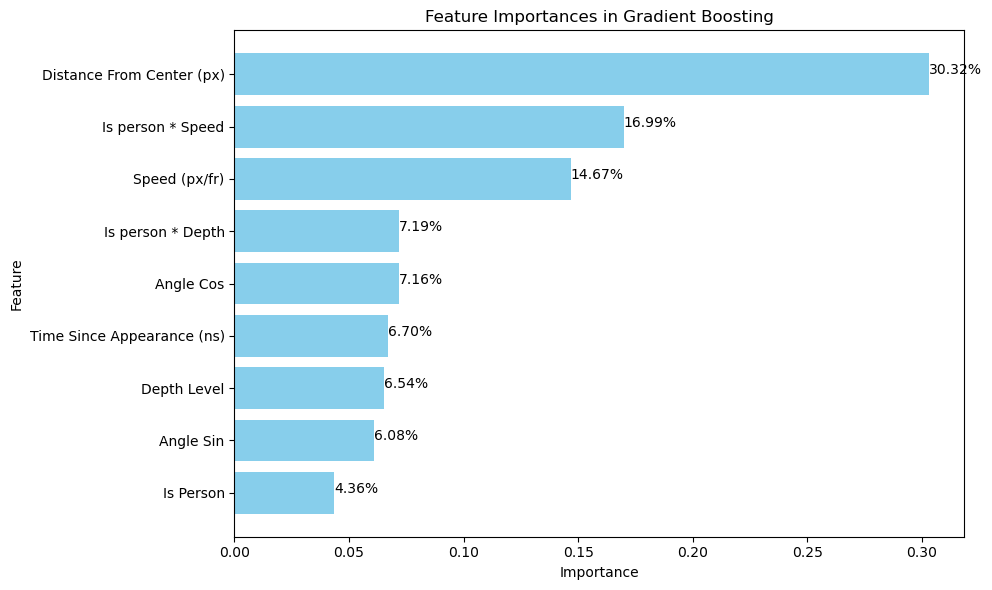

In [41]:
def plot_feature_importance(gbr, feature_names):
    """
    Plot feature importances from a Gradient Boosting Regressor model.

    Args:
        gbr: Trained Gradient Boosting Regressor model.
        feature_names (list): List of feature names.
    """
    # Get the feature importances from the trained model
    importances = gbr.feature_importances_

    # Create a DataFrame to map feature names to their importance
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })

    # Sort the features by importance
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Plot the feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
    # Print exact percentages on the bars
    for index, value in enumerate(feature_importance_df['Importance']):
        plt.text(value, index, f'{value*100:.2f}%')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importances in Gradient Boosting')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

plot_feature_importance(gbr, predictor_labels)

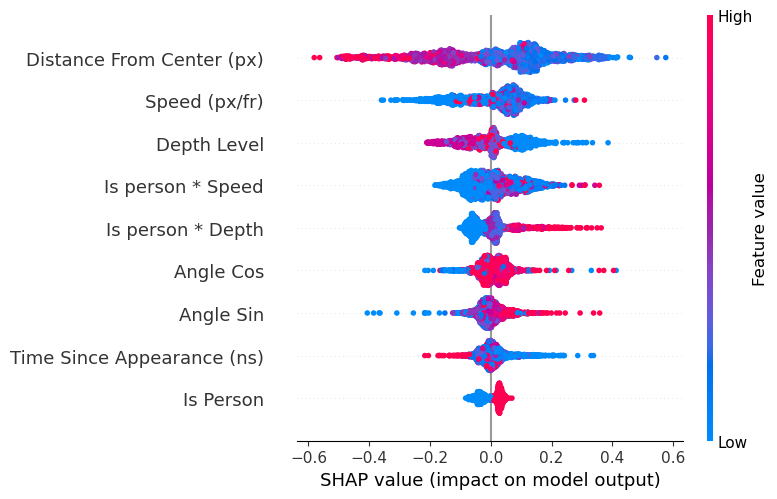

In [42]:
def plot_shap_values(gbr, X_train, feature_names):
    """
    Plot SHAP values to interpret the impact of features on the model's predictions.

    Args:
        gbr: Trained Gradient Boosting Regressor model.
        X_train (ndarray): Training features.
        feature_names (list): List of feature names.
    """
    # Initialize the SHAP explainer for your Gradient Boosting model
    explainer = shap.Explainer(gbr, X_train,)
    
    # Compute SHAP values for the training set
    shap_values = explainer(X_train, check_additivity=False)
    
    # Plot SHAP summary plot
    shap.summary_plot(shap_values, X_train, feature_names=feature_names, )

plot_shap_values(gbr, X, predictor_labels)